# Сопоставление товаров между собой с целью детекции матчей

## Описание проекта

### Постановка задачи

Необходимо решить задачу по матчингу товаров, а именно финальную часть пайплайна матчинга. В ней мы должны принять решение для каждой пары (товар предлагаемый продавцом — товар на площадке), является ли она матчем или нет (бинарная классификация).  
Для этого у каждой пары есть набор признаков и наборы векторов (картиночные и текстовые), которые описывают товары из этой пары.  
В качестве метрики качества решения используется F-score.

### Описание данных

Для решения задачи имеются обезличенные данные по товарным предложениям продавцов (offer) и товарам ассортимента маркетплейса "Мегамаркет" (goods).  
В данных для каждого предложения уже найдены ближайшие товары из ассортимента и указаны основные признаки для этой пары.  
Необходимо только классифицировать, какая из пар является матчем, а какая — нет.

Files  
- *train.csv* - тренировочный набор данных,
- *test.csv* - тестовый набор

Columns
- `offer_depersanalised` и `goods_depersanalised` - идентификаторы предложения и товара соответственно,
- `sum_length` - суммарная длина пары названий и атрибутов в символах,
- `attrs+title_score` - вероятность матча от рескоринговой модели,
- `offer_price` и `item_price` - цена предложения и товара соответственно,
- `goods_category_id` - категория товара,
- `id` - идентификатор пары offer_depersanalised + $ + goods_depersanalised,
- `target` (только в train.csv) - метка класса (0 - не матч, 1 - матч).

Embeddings  
Папки **goods_image_vectors** и **offer_image_vectors** содержат файлы с векторами изображений (*embed_deperson.npy*) и их идентификаторами (*items_deperson.npy*) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.  
Папки **goods_title_vectors** и **offer_title_vectors** содержат файлы с векторами названий+атрибутов (*embed_deperson.npy*) и их идентификаторами (*items_deperson.npy*) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1

In [1]:
# Будем решать задачу классификации, импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.pairwise import paired_cosine_distances

# Очистка оперативной памяти
import gc

# Модель на основе градиентного бустинга (catboost)
from catboost import (
    CatBoostClassifier,
    Pool,
    FeaturesData
)

# Разделение выборок, подбор гиперпараметров
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve  # precision,recall при разных порогах

# Масштабирование и кодирования признаков
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder)
RANDOM_STATE = 5

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Загрузка данных

In [2]:
# Загрузим данные
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
offer_title_ids = np.load('offer_title_vectors/offer_title_vectors/items_deperson.npy')
offer_title_vecs = np.load('offer_title_vectors/offer_title_vectors/embed_deperson.npy')
offer_img_ids = np.load('offer_image_vectors/offer_image_vectors/items_deperson.npy')
offer_img_vecs = np.load('offer_image_vectors/offer_image_vectors/embed_deperson.npy')
goods_title_ids = np.load('goods_title_vectors/goods_title_vectors/items_deperson.npy')
goods_title_vecs = np.load('goods_title_vectors/goods_title_vectors/embed_deperson.npy')
goods_img_ids = np.load('goods_image_vectors/goods_image_vectors/items_deperson.npy')
goods_img_vecs = np.load('goods_image_vectors/goods_image_vectors/embed_deperson.npy')

In [3]:
# Посмотрим первые строки и общие сведения в данных для обучения
print('train')
display(train.head())
train.info()

train


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


In [4]:
# Посмотрим первые строки и общие сведения в тестовой выборке
print('test')
display(test.head())
test.info()

test


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235
2,64819,1396318,38,0.046997,368,NaN,14.0,64819$1396318
3,359959,1396281,40,0.060211,634,NaN,14.0,359959$1396281
4,142700,717657,40,0.000370,14924,31840.0,2.0,142700$717657


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  363835 non-null  int64  
 1   goods_depersanalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB


In [5]:
# Посмотрим размерность таблицы с идентификаторами названий+атрибутов
# по предложениям
print(offer_title_ids.shape)
offer_title_ids

(572767,)


array(['477447', '95232', '117886', ..., '30926', '209577', '239103'],
      dtype='<U6')

In [6]:
# Посмотрим размерность таблицы с векторами названий+атрибутов
# по предложениям
print(offer_title_vecs.shape)
offer_title_vecs

(572767, 64)


array([[ 0.1005  ,  0.01372 ,  0.02437 , ..., -0.0833  , -0.07996 ,
         0.01242 ],
       [-0.0225  , -0.2683  , -0.06757 , ..., -0.07855 , -0.1098  ,
        -0.1461  ],
       [-0.129   , -0.0601  ,  0.132   , ...,  0.0827  , -0.01355 ,
        -0.1091  ],
       ...,
       [ 0.03424 ,  0.1057  , -0.1775  , ...,  0.00539 , -0.07495 ,
        -0.05234 ],
       [ 0.1133  , -0.0424  , -0.01152 , ...,  0.07196 , -0.08386 ,
        -0.04617 ],
       [ 0.02773 ,  0.012505, -0.02528 , ...,  0.04718 , -0.0552  ,
        -0.04034 ]], dtype=float16)

In [7]:
# Посмотрим размерность таблицы с идентификаторами названий+атрибутов
# по товарам с витрины
print(goods_title_ids.shape)
goods_title_ids

(1760568,)


array(['0', '1', '2', ..., '1760565', '1760566', '1760567'], dtype='<U7')

In [8]:
# Посмотрим размерность таблицы с векторами названий+атрибутов
# по товарам с витрины
print(goods_title_vecs.shape)
goods_title_vecs

(1760568, 64)


array([[-0.1097   , -0.03256  , -0.1995   , ...,  0.0008154,  0.01423  ,
        -0.0924   ],
       [ 0.05478  ,  0.0456   ,  0.086    , ...,  0.04526  , -0.0991   ,
         0.0728   ],
       [ 0.1026   , -0.05792  , -0.01443  , ...,  0.02373  ,  0.1375   ,
         0.03757  ],
       ...,
       [-0.1048   ,  0.02689  ,  0.05493  , ..., -0.02917  ,  0.1359   ,
        -0.02756  ],
       [ 0.03458  ,  0.12256  ,  0.08636  , ...,  0.02022  , -0.01162  ,
        -0.11     ],
       [ 0.09845  ,  0.099    , -0.0207   , ...,  0.03278  ,  0.0746   ,
        -0.04443  ]], dtype=float16)

In [9]:
# Посмотрим размерность таблицы с идентификаторами изображений
# по предложениям
print(offer_img_ids.shape)
offer_img_ids

(457586,)


array(['140', '185', '187', ..., '572691', '572699', '572735'],
      dtype='<U6')

In [10]:
# Посмотрим размерность таблицы с векторами изображений
# по предложениям
print(offer_img_vecs.shape)
offer_img_vecs

(457586, 256)


array([[ 0.31286708,  0.9922713 ,  1.2100751 , ..., -1.7545763 ,
        -0.23919716, -1.2425919 ],
       [ 2.4316337 ,  0.9014603 , -0.22259077, ..., -1.1001699 ,
        -1.1482008 , -0.18731171],
       [ 1.0660228 , -0.752132  ,  1.1504172 , ...,  0.9137148 ,
        -0.8000038 , -0.83978504],
       ...,
       [ 0.15886657,  1.1132201 ,  1.8915755 , ..., -1.9614205 ,
         0.25737146,  2.2726674 ],
       [-0.07633805,  1.1760142 ,  1.7563714 , ...,  0.8059396 ,
        -0.01547651, -1.1802496 ],
       [ 2.2704175 , -0.9822532 , -0.21690361, ...,  1.8719108 ,
        -0.7007608 , -1.5808858 ]], dtype=float32)

In [11]:
# Посмотрим размерность таблицы с идентификаторами изображений
# по товарам с витрины
print(goods_img_ids.shape)
goods_img_ids

(317707,)


array(['37', '39', '49', ..., '1749527', '1749528', '1749541'],
      dtype='<U7')

In [12]:
# Посмотрим размерность таблицы с векторами названий+атрибутов
# по товарам с витрины
print(goods_img_vecs.shape)
goods_img_vecs

(317707, 256)


array([[ 1.1158133 ,  1.9842914 ,  0.5167014 , ..., -0.69889563,
         0.11544477, -3.1679373 ],
       [ 0.99327075,  1.9756604 ,  0.23954017, ...,  0.00989665,
         0.49230903, -3.0051124 ],
       [-0.36902365, -2.316401  ,  1.3042173 , ..., -1.6195703 ,
         0.7884472 , -2.6850224 ],
       ...,
       [-0.16678151, -0.6597981 , -0.9382939 , ...,  0.3883793 ,
        -0.21414155,  0.41041985],
       [-0.16678151, -0.6597981 , -0.9382939 , ...,  0.3883793 ,
        -0.21414155,  0.41041985],
       [-0.16678151, -0.6597981 , -0.9382939 , ...,  0.3883793 ,
        -0.21414155,  0.41041985]], dtype=float32)

## Исследовательский анализ данных

### Пропуски

In [13]:
# Посмотрим количество пропусков в обучающей выборке
pd.concat(
    [train.isna().sum(), train.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'count', 1: 'part' }
)

,count,part
offer_depersanalised,0,0.000000
goods_depersanalised,0,0.000000
sum_length,0,0.000000
attrs+title_score,0,0.000000
offer_price,0,0.000000
goods_price,407287,0.161722
goods_category_id,833,0.000331
target,0,0.000000
id,0,0.000000


In [14]:
# Посмотрим количество пропусков в тестовой выборке
pd.concat(
    [test.isna().sum(), test.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'count', 1: 'part' }
)

,count,part
offer_depersanalised,0,0.000000
goods_depersanalised,0,0.000000
sum_length,0,0.000000
attrs+title_score,0,0.000000
offer_price,0,0.000000
goods_price,58971,0.162082
goods_category_id,131,0.000360
id,0,0.000000


Как видим, имеются пропуски в столбцах `goods_price`, `goods_category_id` как в обучающей, так и в тестовой выборке. Доля пропусков в обучающей и в тестовой выборках приблизительно одинакова. Данных, которые позволили бы обоснованно заполнить пропуски, у нас в распоряжении нет, поэтому пока оставим их.

### Типы

Тип данных в столбце `goods_category_id` не соответствует целочисленному содержимому из-за наличия пропусков, по остальным столбцам тип данных соответствуют содержимому.

### Дубликаты

In [15]:
# Изучим данные для обучения подробнее
print('Обучающая выборка')
print(f'Всего строк {train.shape[0]}')
print(
    f'Уникальных идентификаторов предложения: {train["offer_depersanalised"].nunique()}'
)
print(
    f'Уникальных идентификаторов товаров: {train["goods_depersanalised"].nunique()}'
)
print(
    f'Уникальных идентификаторов пары предложение-товар: {train["id"].nunique()}'
)
print(f'Полных дубликатов: {train.duplicated().sum()}')

Обучающая выборка
Всего строк 2518441
Уникальных идентификаторов предложения: 500000
Уникальных идентификаторов товаров: 1592607
Уникальных идентификаторов пары предложение-товар: 2500000
Полных дубликатов: 0


In [16]:
# Изучим тестовые данные подробнее
print('Тестовая выборка')
print(f'Всего строк {test.shape[0]}')
print(f'Уникальных идентификаторов предложения: {test["offer_depersanalised"].nunique()}')
print(f'Уникальных идентификаторов товаров: {test["goods_depersanalised"].nunique()}')
print(f'Уникальных идентификаторов пары предложение-товар: {test["id"].nunique()}')
print(f'Полных дубликатов: {test.duplicated().sum()}')

Тестовая выборка
Всего строк 363835
Уникальных идентификаторов предложения: 72767
Уникальных идентификаторов товаров: 316987
Уникальных идентификаторов пары предложение-товар: 363835
Полных дубликатов: 0


Видим, что имеются дубликаты пар предложение-товар в обучающей выборке. Посмотрим на строки с дубликатами.

In [17]:
train[train['id'].duplicated(keep=False)].head(10)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
652,357107,851154,56,0.000048,7579,34952.0,82.0,0,357107$851154
653,357107,851154,56,0.000048,7579,34952.0,81.0,0,357107$851154
4850,19880,790671,67,0.000038,4658,2960.0,83.0,0,19880$790671
4851,19880,790671,67,0.000038,4658,2960.0,82.0,0,19880$790671
5337,21236,790671,67,0.076294,3037,2960.0,83.0,0,21236$790671
5338,21236,790671,67,0.076294,3037,2960.0,82.0,0,21236$790671
10889,314195,790669,74,0.000041,1607,1833.0,83.0,0,314195$790669
10890,314195,790669,74,0.000041,1607,1833.0,82.0,0,314195$790669
12158,314243,790669,75,0.000116,1127,1833.0,83.0,0,314243$790669
12159,314243,790669,75,0.000116,1127,1833.0,82.0,0,314243$790669


In [18]:
# Посчитаем, сколько уникальных объектов дублируется и сколько всего объектов
# среди которых имеются дубли
print(train[train['id'].duplicated(keep='first')].shape[0])
train[train['id'].duplicated(keep=False)].shape[0]

18441


36882

Видим, что имеются 18441 пар предложение-товар, для которых имеется по одной дублирующей паре, отличающейся, предположительно, только значением в столбце `goods_category_id`. Убедимся в том, что отличие только в категории товара.

In [19]:
print(
    train[
        train[
            ['offer_depersanalised', 'goods_depersanalised', 'sum_length',
       'attrs+title_score', 'offer_price', 'goods_price', 'target', 'id']
        ].duplicated(keep='first')
    ].shape[0]
)
print(
    train[
        train[
            ['offer_depersanalised', 'goods_depersanalised', 'sum_length',
       'attrs+title_score', 'offer_price', 'goods_price', 'target', 'id']
        ].duplicated(keep=False)
    ].shape[0]
)

18441
36882


Предположение оказалось верным. Значение целевого признака у дублирующихся строк не отличается, отличие лишь в категории товара. Таким образом, один товар отнесён к разным категориям, что похоже на ошибку. Удалим дубликаты по столбцу идентификатор пары предложение-товар `id`.

In [20]:
train = train[~train['id'].duplicated(keep='first')]

In [21]:
# Обновим индексы в обучающей выборке
train = train.reset_index(drop=True)

In [22]:
# Посмотрим общие сведения после преобразований
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 171.7+ MB


In [23]:
# Посмотрим количество пропусков в обучающей выборке после изменений
pd.concat(
    [train.isna().sum(), train.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'count', 1: 'part' }
)

,count,part
offer_depersanalised,0,0.000000
goods_depersanalised,0,0.000000
sum_length,0,0.000000
attrs+title_score,0,0.000000
offer_price,0,0.000000
goods_price,404807,0.161923
goods_category_id,833,0.000333
target,0,0.000000
id,0,0.000000


Изучим таблицы с идентификаторами и векторами названий+атрибутов и изображений

In [24]:
print('Названия+атрибуты по предложениям')
print('Идентификаторы')
print(
    f'Уникальных {np.unique(offer_title_ids).shape}, всего {offer_title_ids.shape}'
)
print('Векторы')
print(
    f'Уникальных {np.unique(offer_title_vecs, axis=0).shape}, всего {offer_title_vecs.shape}'
)
print()
print('Названия+атрибуты по товарам')
print('Идентификаторы')
print(
    f'Уникальных {np.unique(goods_title_ids).shape}, всего {goods_title_ids.shape}'
)
print('Веткоры')
print(
    f'Уникальных {np.unique(goods_title_vecs, axis=0).shape}, всего {goods_title_vecs.shape}'
)
print()
print('Изображения по предложениям')
print('Идентификаторы')
print(
    f'Уникальных {np.unique(offer_img_ids).shape}, всего {offer_img_ids.shape}'
)
print('Векторы')
print(
    f'Уникальных {np.unique(offer_img_vecs, axis=0).shape}, всего {offer_img_vecs.shape}'
)
print()
print('Изображения по товарам')
print('Идентификаторы')
print(
    f'Уникальных {np.unique(goods_img_ids).shape}, всего {goods_img_ids.shape}'
)
print('Векторы')
print(
    f'Уникальных {np.unique(goods_img_vecs, axis=0).shape}, всего {goods_img_vecs.shape}'
)

Названия+атрибуты по предложениям
Идентификаторы
Уникальных (572767,), всего (572767,)
Векторы
Уникальных (553205, 64), всего (572767, 64)

Названия+атрибуты по товарам
Идентификаторы
Уникальных (1760568,), всего (1760568,)
Веткоры
Уникальных (1757566, 64), всего (1760568, 64)

Изображения по предложениям
Идентификаторы
Уникальных (457585,), всего (457586,)
Векторы
Уникальных (415837, 256), всего (457586, 256)

Изображения по товарам
Идентификаторы
Уникальных (312554,), всего (317707,)
Векторы
Уникальных (275296, 256), всего (317707, 256)


Выводы:
- векторы текстов название+атрибуты повторяются для некоторых идентификаторов,
- векторы изображений повторяются для некоторых идентификаторов, 
- имеются неуникальные идентификаторы изображений по предложениям и по товарам, т.е. для одного идентификатора имеется несколько векторов. Это похоже на ошибку. Удалим дубликаты.

In [25]:
# Оставим только уникальные значения для предложений
offer_img_ids, indices = np.unique(offer_img_ids, return_index=True)
offer_img_vecs = offer_img_vecs[indices]

In [26]:
# Оставим только уникальные значения для товаров
goods_img_ids, indices = np.unique(goods_img_ids, return_index=True)
goods_img_vecs = goods_img_vecs[indices]
# Избавимся от лишних переменных
del indices
gc.collect()

0

In [27]:
# Проверим, что получилось
print('Изображения по предложениям')
print('Идентификаторы')
print(
    f'Уникальных {np.unique(offer_img_ids).shape}, всего {offer_img_ids.shape}'
)
print('Векторы')
print(
    f'Уникальных {np.unique(offer_img_vecs, axis=0).shape}, всего {offer_img_vecs.shape}'
)
print()
print('Изображения по товарам')
print('Идентификаторы')
print(
    f'Уникальных {np.unique(goods_img_ids).shape}, всего {goods_img_ids.shape}'
)
print('Векторы')
print(
    f'Уникальных {np.unique(goods_img_vecs, axis=0).shape}, всего {goods_img_vecs.shape}'
)

Изображения по предложениям
Идентификаторы
Уникальных (457585,), всего (457585,)
Векторы
Уникальных (415836, 256), всего (457585, 256)

Изображения по товарам
Идентификаторы
Уникальных (312554,), всего (312554,)
Векторы
Уникальных (270785, 256), всего (312554, 256)


Объёдиним идентификаторы и векторы во всех таблицах.

In [28]:
# Названия+атрибуты товаров
goods_titles = pd.concat([
    pd.DataFrame(goods_title_ids, columns=['gtitle_id']),
    pd.DataFrame(
        goods_title_vecs,
        columns=['gtvec_' + str(i) for i in range(goods_title_vecs.shape[1])])
],
    axis=1)
print('Размер', goods_titles.shape)
# Приведём тип id к целочисленному
goods_titles['gtitle_id'] = goods_titles['gtitle_id'].astype(int)
goods_titles.head()

Размер (1760568, 65)


,gtitle_id,gtvec_0,gtvec_1,gtvec_2,gtvec_3,gtvec_4,gtvec_5,gtvec_6,gtvec_7,gtvec_8,...,gtvec_54,gtvec_55,gtvec_56,gtvec_57,gtvec_58,gtvec_59,gtvec_60,gtvec_61,gtvec_62,gtvec_63
0,0,-0.109680,-0.032562,-0.199463,0.035004,0.003799,0.134521,-0.064819,-0.073120,-0.005131,...,0.107788,0.078552,0.061401,-0.047516,-0.017242,0.136963,-0.085449,0.000815,0.014229,-0.092407
1,1,0.054779,0.045593,0.085999,-0.030533,-0.084595,-0.072876,0.145874,-0.084473,0.046692,...,0.057220,-0.077637,0.031067,0.033691,-0.102173,0.057465,-0.036652,0.045258,-0.099121,0.072815
2,2,0.102600,-0.057922,-0.014427,-0.018524,-0.029694,0.106750,0.022720,0.046661,-0.111755,...,0.091797,-0.006828,0.164551,0.076721,0.116211,0.017059,-0.080322,0.023727,0.137451,0.037567
3,3,-0.048004,-0.044464,-0.088684,-0.059753,-0.121338,-0.120728,-0.057922,-0.073608,0.002689,...,-0.033752,0.156738,0.061005,-0.014679,-0.025574,0.090759,0.015945,-0.045868,0.096069,-0.037323
4,4,-0.039825,-0.001688,-0.117676,-0.086487,-0.080139,0.068359,-0.024521,-0.108521,-0.049652,...,0.062561,0.070251,-0.012901,-0.053528,0.038666,0.166138,-0.088318,0.059509,-0.004223,-0.115845


In [29]:
# Проверим дубликаты
goods_titles.duplicated().sum()

0

In [30]:
# Названия+атрибуты предложений
offer_titles = pd.concat([
    pd.DataFrame(offer_title_ids, columns=['otitle_id']),
    pd.DataFrame(
        offer_title_vecs,
        columns=['otvec_' + str(i) for i in range(offer_title_vecs.shape[1])])
],
    axis=1)
print('Размер', offer_titles.shape)
# Приведём тип id к целочисленному
offer_titles['otitle_id'] = offer_titles['otitle_id'].astype(int)
offer_titles.head()

Размер (572767, 65)


,otitle_id,otvec_0,otvec_1,otvec_2,otvec_3,otvec_4,otvec_5,otvec_6,otvec_7,otvec_8,...,otvec_54,otvec_55,otvec_56,otvec_57,otvec_58,otvec_59,otvec_60,otvec_61,otvec_62,otvec_63
0,477447,0.100525,0.013718,0.024368,-0.056488,-0.067505,-0.107422,0.029984,0.031647,-0.089661,...,-0.078735,-0.006485,0.047974,-0.070312,0.082764,-0.006165,0.168091,-0.083313,-0.079956,0.012421
1,95232,-0.022507,-0.268311,-0.067566,-0.040192,-0.031021,-0.046143,0.133301,0.106384,-0.092224,...,0.132080,-0.008453,-0.096069,0.018326,-0.100281,-0.153198,-0.021912,-0.078552,-0.109802,-0.146118
2,117886,-0.129028,-0.060089,0.131958,0.009232,-0.077454,-0.015808,-0.101318,0.055237,-0.005966,...,0.080994,-0.024506,0.029648,-0.010521,-0.000416,0.019699,0.032410,0.082703,-0.013550,-0.109070
3,218467,-0.160645,-0.020462,0.037384,-0.096130,0.000004,0.106567,-0.075500,-0.083557,0.038239,...,-0.075623,0.062317,-0.091064,0.105835,-0.053680,-0.058594,-0.208374,0.018951,0.095276,-0.009026
4,399432,0.094971,0.005981,0.009201,-0.033356,-0.007111,-0.013527,0.043488,0.140259,0.016403,...,0.015488,0.200317,-0.184448,0.059723,0.018509,-0.057800,-0.075195,-0.016342,-0.046661,0.072388


In [31]:
# Проверим дубликаты
offer_titles.duplicated().sum()

0

In [32]:
# Изображения товаров
goods_imgs = pd.concat([
    pd.DataFrame(goods_img_ids, columns=['gimg_id']),
    pd.DataFrame(
        goods_img_vecs,
        columns=['gimvec_' + str(i) for i in range(goods_img_vecs.shape[1])])
],
    axis=1)
print('Размер', goods_imgs.shape)
# Приведём тип id к целочисленному
goods_imgs['gimg_id'] = goods_imgs['gimg_id'].astype(int)
# Уменьшим размерность чисел в эмбеддингах
goods_imgs.iloc[:, 1:] = goods_imgs.iloc[:, 1:].astype('float16')
goods_imgs.head()

Размер (312554, 257)


,gimg_id,gimvec_0,gimvec_1,gimvec_2,gimvec_3,gimvec_4,gimvec_5,gimvec_6,gimvec_7,gimvec_8,...,gimvec_246,gimvec_247,gimvec_248,gimvec_249,gimvec_250,gimvec_251,gimvec_252,gimvec_253,gimvec_254,gimvec_255
0,10000,-0.620605,-0.983398,1.471680,-0.622070,1.050781,-0.905762,1.975586,1.486328,-0.272705,...,0.180420,2.384766,3.072266,0.233887,1.608398,-0.879395,-1.244141,-1.869141,-1.704102,-0.387207
1,1000017,-0.166748,-0.659668,-0.938477,0.283203,0.204956,-0.058350,-0.267334,-0.515137,0.482422,...,0.286377,-0.093628,-0.051910,-0.759277,-0.491699,0.032654,0.636230,0.388428,-0.214111,0.410400
2,1000018,-0.166748,-0.659668,-0.938477,0.283203,0.204956,-0.058350,-0.267334,-0.515137,0.482422,...,0.286377,-0.093628,-0.051910,-0.759277,-0.491699,0.032654,0.636230,0.388428,-0.214111,0.410400
3,100002,-1.750977,-0.520508,0.922363,-0.677734,-1.461914,-0.413330,-1.383789,0.948242,-1.059570,...,1.268555,-0.216309,0.830078,1.569336,-0.442383,-0.728027,0.222656,-1.440430,0.341064,1.308594
4,1000031,-0.166748,-0.659668,-0.938477,0.283203,0.204956,-0.058350,-0.267334,-0.515137,0.482422,...,0.286377,-0.093628,-0.051910,-0.759277,-0.491699,0.032654,0.636230,0.388428,-0.214111,0.410400


In [33]:
# Проверим дубликаты
goods_imgs.duplicated().sum()

0

In [34]:
# Изображения предложений
offer_imgs = pd.concat([
    pd.DataFrame(offer_img_ids, columns=['oimg_id']),
    pd.DataFrame(
        offer_img_vecs,
        columns=['oimvec_' + str(i) for i in range(offer_img_vecs.shape[1])])
],
    axis=1)
print('Размер', offer_imgs.shape)
# Приведём тип id к целочисленному
offer_imgs['oimg_id'] = offer_imgs['oimg_id'].astype(int)
# Уменьшим размерность чисел в эмбеддингах
offer_imgs.iloc[:, 1:] = offer_imgs.iloc[:, 1:].astype('float16')
offer_imgs.head()

Размер (457585, 257)


,oimg_id,oimvec_0,oimvec_1,oimvec_2,oimvec_3,oimvec_4,oimvec_5,oimvec_6,oimvec_7,oimvec_8,...,oimvec_246,oimvec_247,oimvec_248,oimvec_249,oimvec_250,oimvec_251,oimvec_252,oimvec_253,oimvec_254,oimvec_255
0,0,0.556641,0.697754,1.226562,-0.920898,0.824707,0.354980,-2.072266,2.154297,-0.103149,...,1.013672,0.193604,-2.406250,2.482422,-2.236328,-1.785156,1.314453,0.619141,0.662598,0.887207
1,1,-0.017044,1.729492,1.513672,-1.117188,3.679688,0.498047,-1.474609,0.303467,-1.890625,...,-0.670898,2.087891,-0.135498,-1.485352,3.064453,1.156250,1.794922,-1.472656,-0.692871,-0.484863
2,10,1.441406,0.359375,0.849609,-0.408691,-0.015961,2.386719,1.600586,-1.319336,1.126953,...,1.047852,-1.003906,-0.230103,1.867188,2.572266,1.236328,-2.166016,0.868164,3.054688,2.810547
3,100,2.962891,1.814453,1.125000,0.461182,-0.561035,-1.038086,-3.087891,0.617676,1.300781,...,-1.922852,0.230225,0.644043,2.300781,1.769531,0.158936,0.712891,-0.211182,-0.185181,-1.470703
4,100000,-0.097290,0.613281,-0.607422,-0.948730,0.168823,0.748535,1.179688,-1.015625,1.561523,...,-1.565430,0.274170,1.110352,1.842773,0.340820,0.568848,-1.417969,-0.443848,-0.139648,1.499023


In [35]:
# Проверим дубликаты
offer_imgs.duplicated().sum()

0

In [36]:
# Освободим память
del goods_img_ids, goods_img_vecs, offer_img_ids, offer_img_vecs, \
    goods_title_ids, goods_title_vecs, offer_title_ids, offer_title_vecs
gc.collect()

0

### Идентификаторы

In [37]:
# Убедимся, что идентификаторы предложений в столбце offer_depersanalised
# совпадают с идентификатором предложений в столбце id 
(train['id'].str.split('$').str[0].astype(int) != train['offer_depersanalised']).sum()

0

In [38]:
# Убедимся, что идентификаторы товаров в столбце goods_depersanalised
# совпадают с идентификатором товара в столбце id 
(train['id'].str.split('$').str[1].astype(int) != train['goods_depersanalised']).sum()

0

In [39]:
# аналогичные проверки сделаем для тестовой выборки
# в столбце offer_depersanalised
(test['id'].str.split('$').str[0].astype(int) != test['offer_depersanalised']).sum()

0

In [40]:
# в столбце goods_depersanalised
(test['id'].str.split('$').str[1].astype(int) != test['goods_depersanalised']).sum()

0

Взаимно однозначное соответствие установлено

In [41]:
# Проверим наличие текстовых эмбеддингов
print('Нет векторов названий+атрибутов для:')
print('обучающая выборка')
print(f'{len(set(train["offer_depersanalised"]) - set(offer_titles["otitle_id"]))} уникальных предложений')
print(f'из {len(set(train["offer_depersanalised"]))}')
print(f'{len(set(train["goods_depersanalised"]) - set(goods_titles["gtitle_id"]))} уникальных товаров')
print(f'из {len(set(train["goods_depersanalised"]))}')
print()
print('тестовая выборка')
print(f'{len(set(test["offer_depersanalised"]) - set(offer_titles["otitle_id"]))} уникальных предложений')
print(f'из {len(set(test["offer_depersanalised"]))}')
print(f'{len(set(test["goods_depersanalised"]) - set(goods_titles["gtitle_id"]))} уникальных товаров')
print(f'из {len(set(test["goods_depersanalised"]))}')

Нет векторов названий+атрибутов для:
обучающая выборка
0 уникальных предложений
из 500000
0 уникальных товаров
из 1592607

тестовая выборка
0 уникальных предложений
из 72767
0 уникальных товаров
из 316987


In [42]:
# Проверим наличие эмбеддингов изображений
print('Нет векторов изображений для:')
print('обучающая выборка')
print(f'{len(set(train["offer_depersanalised"]) - set(offer_imgs["oimg_id"]))} уникальных предложений')
print(f'из {len(set(train["offer_depersanalised"]))}')
print(f'{len(set(train["goods_depersanalised"]) - set(goods_imgs["gimg_id"]))} уникальных товаров')
print(f'из {len(set(train["goods_depersanalised"]))}')
print()
print('тестовая выборка')
print(f'{len(set(test["offer_depersanalised"]) - set(offer_imgs["oimg_id"]))} уникальных предложений')
print(f'из {len(set(test["offer_depersanalised"]))}')
print(f'{len(set(test["goods_depersanalised"]) - set(goods_imgs["gimg_id"]))} уникальных товаров')
print(f'из {len(set(test["goods_depersanalised"]))}')

Нет векторов изображений для:
обучающая выборка
100666 уникальных предложений
из 500000
1304588 уникальных товаров
из 1592607

тестовая выборка
14516 уникальных предложений
из 72767
249581 уникальных товаров
из 316987


Видим, что текстовые эмбеддинги имеются для всех предложений и товаров, а эмбеддинги изображений отсутствуют для большинства товаров и ~20% предложений.

### Цены

#### Цены предложений

Посмотрим, как распределены цены предложений

In [43]:
# Посмотрим основные статистики
train['offer_price'].describe()

count    2.500000e+06
mean     9.345912e+05
std      9.560908e+06
min      1.010000e+02
25%      9.890000e+02
50%      2.830000e+03
75%      9.280000e+03
max      1.000001e+08
Name: offer_price, dtype: float64

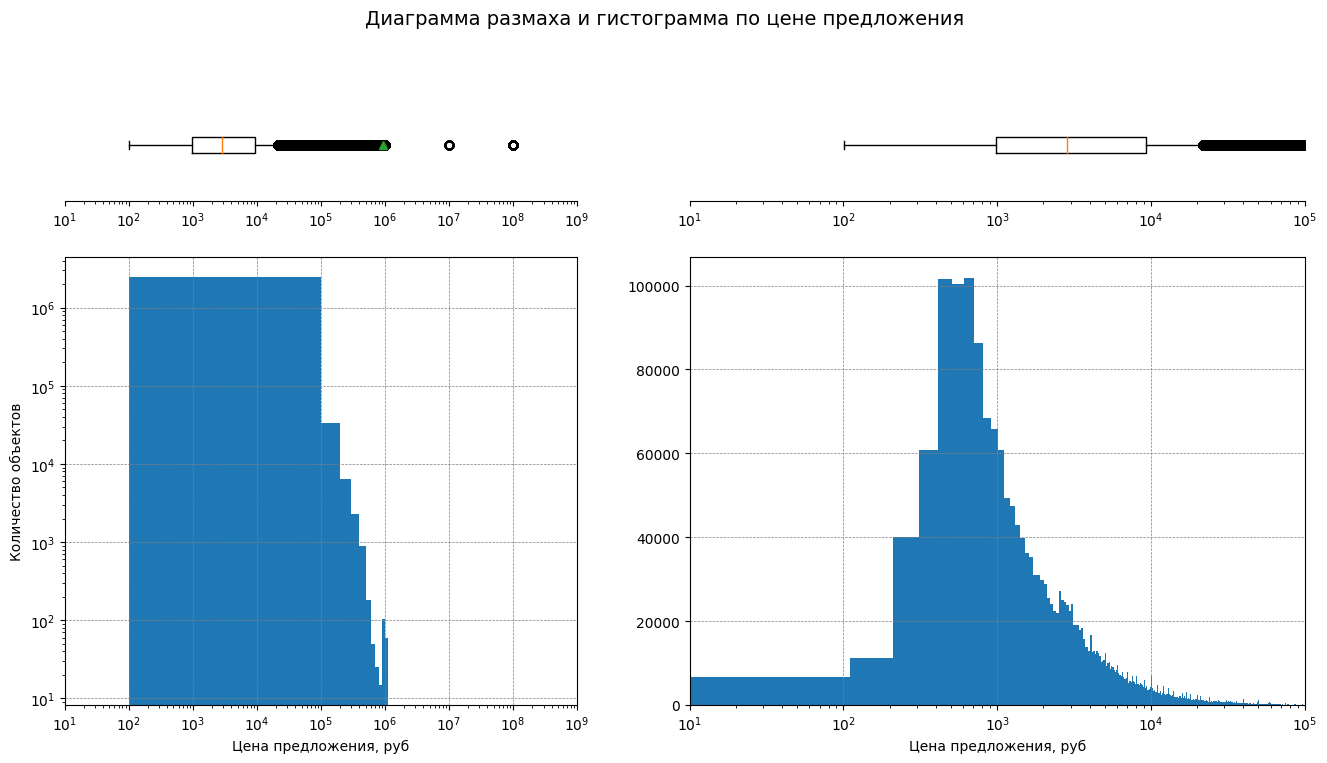

In [44]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку цена в большинстве объектов не превышает 10000 руб, а максимальная цена 1e8 руб,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 1e5 руб.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 8),
    sharex=False,
    gridspec_kw={
        'height_ratios': (.2, .8),
        'width_ratios': (.5, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по цене предложения', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(10,1e9)
ax[1,1].set_xlim(10,1e5)
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,0].set_xlabel('Цена предложения, руб')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Цена предложения, руб')
# Построим сами диаграммы
ax[1,0].hist(train['offer_price'], bins=1000)
ax[1,1].hist(train['offer_price'], bins=1000, range=(10,1e5))
ax[0,0].boxplot(train['offer_price'], vert=False, showmeans=True)
ax[0,1].boxplot(train['offer_price'], vert=False, showmeans=True)
plt.show()

Видим, что диапазон цен предложений очень широкий, но почти все значения в диапазоне до 100 тыс руб. При этом есть выбросы до 100 млн руб, что, вероятно, является ошибкой в данных.

In [45]:
# Посмотрим строки, у которых цена предложения выше 500 тыс
train[train['offer_price']>500000]['offer_price'].value_counts()

offer_price
100000100    23070
1000099        100
10000099        80
1005100         60
549100          10
500090          10
573486           5
527460           5
500722           5
618100           5
551008           5
502190           5
574534           5
814990           5
672820           5
606530           5
580290           5
579226           5
526612           5
551880           5
710530           5
534390           5
619200           5
841160           5
557970           5
594341           5
871215           5
521734           5
525936           5
549826           5
593658           5
577310           5
538210           5
641245           5
564090           5
563090           5
527810           5
640100           5
622400           5
732439           5
572146           5
636600           5
772966           5
569500           5
599007           5
924484           5
522090           5
504160           5
543460           5
619260           5
558175           5
598444           5


In [46]:
train[train['offer_price']==1005100].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
160871,484450,915701,136,0.000038,1005100,2505.0,2.0,0,484450$915701
160932,484450,915700,136,0.000038,1005100,2775.0,2.0,0,484450$915700
193361,484892,888485,144,0.004330,1005100,9009.0,2.0,0,484892$888485
234437,484891,771226,153,0.000042,1005100,699.0,5.0,0,484891$771226
248923,491018,768653,156,0.000033,1005100,3090.0,19.0,0,491018$768653


In [47]:
train[train['offer_price']==10000099].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
77026,513036,1212998,110,0.000156,10000099,24090.0,8.0,0,513036$1212998
77037,513008,829684,110,0.106323,10000099,15420.0,82.0,0,513008$829684
77112,513008,859849,110,0.017181,10000099,17090.0,8.0,0,513008$859849
79316,513204,859849,111,0.000106,10000099,17090.0,8.0,0,513204$859849
79448,513204,829684,111,0.000117,10000099,15420.0,82.0,0,513204$829684


In [48]:
train[train['offer_price']==1000099].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
148479,1247,885523,133,0.034180,1000099,5630.0,82.0,0,1247$885523
212084,1254,876465,148,0.000033,1000099,5900.0,83.0,0,1254$876465
222180,1273,1057061,150,0.000034,1000099,546.0,8.0,0,1273$1057061
222521,1246,1096046,150,0.000213,1000099,8980.0,81.0,0,1246$1096046
250734,1253,675648,157,0.000035,1000099,14491.0,5.0,0,1253$675648


In [49]:
train[train['offer_price']==100000100].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
3712,414316,1196909,65,0.051178,100000100,NaN,11.0,0,414316$1196909
6455,409602,862486,69,0.000037,100000100,41797.0,8.0,0,409602$862486
7918,407047,1374959,71,0.105774,100000100,11950.0,2.0,0,407047$1374959
10347,410598,876732,74,0.051086,100000100,140618.0,8.0,0,410598$876732
11326,407821,851153,74,0.147217,100000100,8092.0,81.0,0,407821$851153


In [50]:
test['offer_price'].describe()

count    3.638350e+05
mean     9.583577e+05
std      9.683426e+06
min      1.010000e+02
25%      9.820000e+02
50%      2.832000e+03
75%      9.321000e+03
max      1.000001e+08
Name: offer_price, dtype: float64

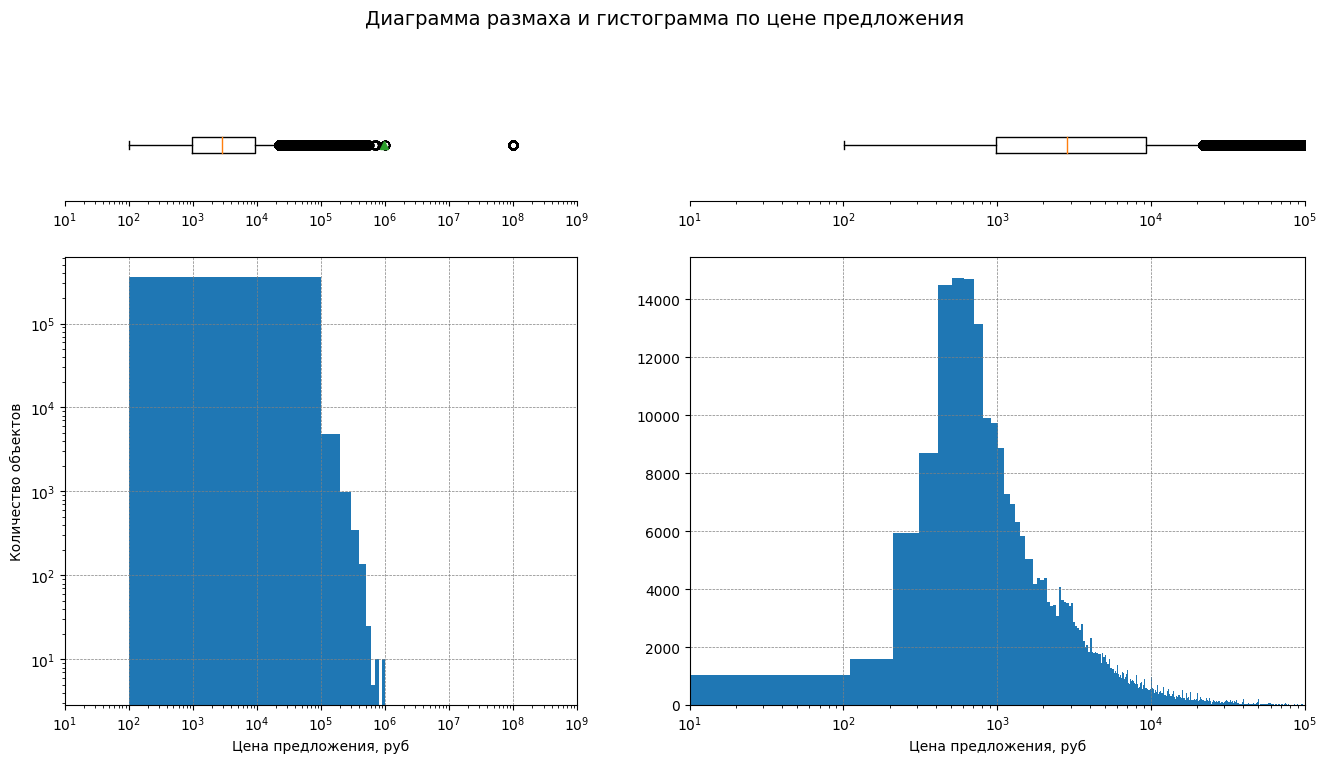

In [51]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку цена в большинстве объектов не превышает 10000 руб, а максимальная цена 1e8 руб,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 1e5 руб.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 8),
    sharex=False,
    gridspec_kw={
        'height_ratios': (.2, .8),
        'width_ratios': (.5, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по цене предложения', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(10,1e9)
ax[1,1].set_xlim(10,1e5)
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,0].set_xlabel('Цена предложения, руб')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Цена предложения, руб')
# Построим сами диаграммы
ax[1,0].hist(test['offer_price'], bins=1000)
ax[1,1].hist(test['offer_price'], bins=1000, range=(10,1e5))
ax[0,0].boxplot(test['offer_price'], vert=False, showmeans=True)
ax[0,1].boxplot(test['offer_price'], vert=False, showmeans=True)
plt.show()

Видим, что диапазон цен ориентировочно такой же, как в обучающей выборке.

In [52]:
# Посмотрим строки, у которых цена предложения выше 500 тыс
test[test['offer_price']>500000]['offer_price'].value_counts()

offer_price
100000100    3445
1000099        10
538100          5
503590          5
565370          5
665464          5
525550          5
542550          5
730400          5
719830          5
Name: count, dtype: int64

In [53]:
test[test['offer_price']==1000099].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
35449,1252,823464,155,0.000034,1000099,30388.0,8.0,1252$823464
172696,1252,447682,475,0.000066,1000099,1284.0,83.0,1252$447682
190265,1258,217231,529,0.000755,1000099,399.0,11.0,1258$217231
262153,1258,280199,752,0.926270,1000099,2890.0,11.0,1258$280199
265114,1252,91903,765,0.000039,1000099,46465.0,14.0,1252$91903


In [54]:
test[test['offer_price']==100000100].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
2296,408551,728508,77,0.000036,100000100,2400.0,8.0,408551$728508
3362,414572,1205708,82,0.076538,100000100,NaN,2.0,414572$1205708
3512,409912,874202,83,0.000156,100000100,30810.0,8.0,409912$874202
3886,413643,1376627,84,0.046295,100000100,23750.0,2.0,413643$1376627
4205,407112,1057012,86,0.000033,100000100,712.0,81.0,407112$1057012


Видим, что значения 100000100, 1000099, 10000099, 1005100 похожи на ошибочные. Обоснованно заменить их на нормальные значения мы не можем, поэтому оставим их без изменения.

#### Цены товаров

Посмотрим, как распределены цены товаров

In [55]:
train['goods_price'].describe()

count    2.095193e+06
mean     4.828590e+04
std      7.969484e+06
min      1.010000e+02
25%      6.640000e+02
50%      1.772000e+03
75%      6.498000e+03
max      2.106021e+09
Name: goods_price, dtype: float64

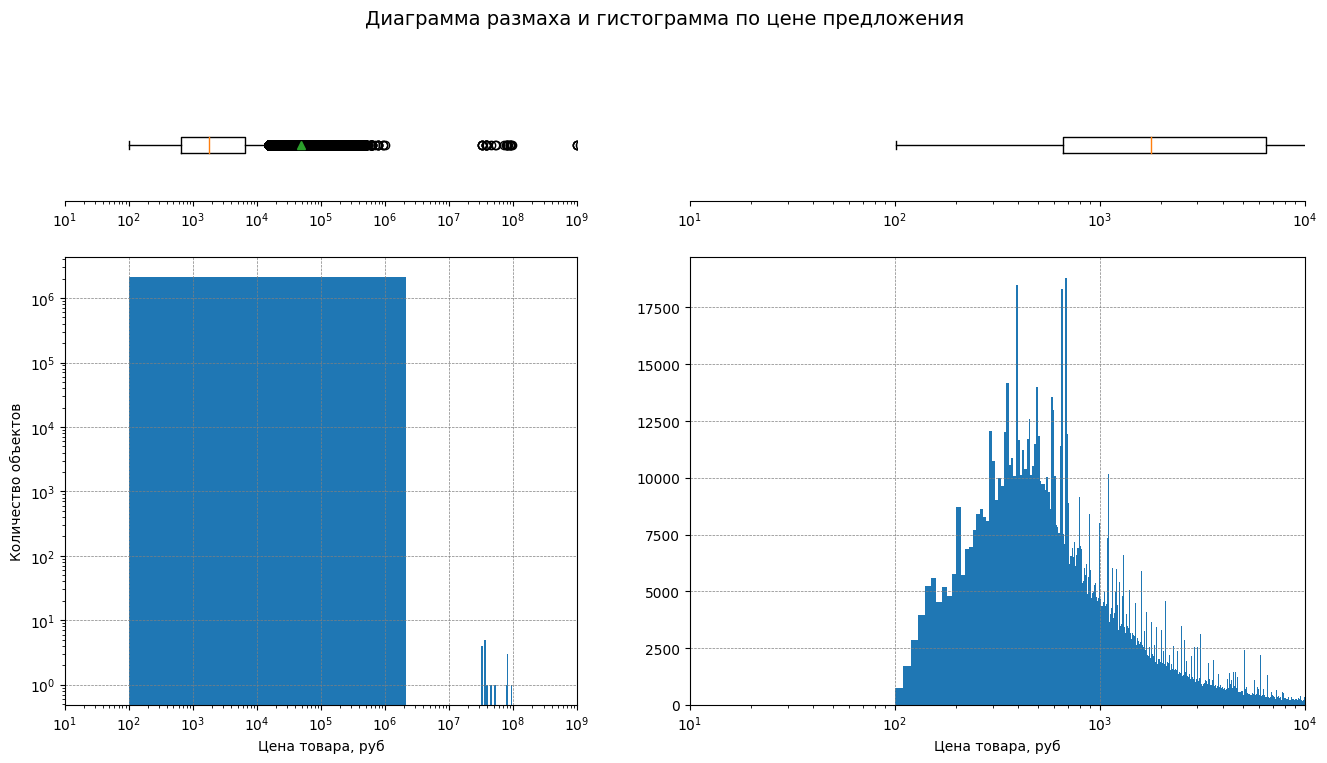

In [56]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку цена в большинстве объектах не превышает 10000 руб, а максимальная цена 2e9 руб,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 1e4 руб.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 8),
    sharex=False,
    gridspec_kw={
        'height_ratios': (.2, .8),
        'width_ratios': (.5, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по цене предложения', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(10,1e9)
ax[1,1].set_xlim(10,1e4)
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,0].set_xlabel('Цена товара, руб')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Цена товара, руб')
# Построим сами диаграммы
ax[1,0].hist(train['goods_price'], bins=1000)
ax[1,1].hist(train['goods_price'], bins=1000, range=(10,1e4))
ax[0,0].boxplot(train[~train['goods_price'].isna()]['goods_price'], vert=False, showmeans=True)
ax[0,1].boxplot(train[~train['goods_price'].isna()]['goods_price'], vert=False, showmeans=True)
plt.show()

Видим, что диапазон цен ориентировочно такой же, как и у предложений.

In [57]:
# Посмотрим строки, у которых цена предложения выше 500 тыс
train[train['goods_price']>500000]['goods_price'].value_counts()

goods_price
5.000990e+05    17
1.638016e+09    10
6.300990e+05     5
3.750385e+07     5
5.000900e+05     4
7.808800e+05     4
1.326013e+09     4
6.100990e+05     4
1.014010e+09     3
1.482015e+09     3
1.872019e+09     3
1.358014e+09     3
8.120822e+07     3
2.106021e+09     3
9.050915e+07     3
3.260336e+07     3
1.404014e+09     2
1.982020e+09     2
1.436014e+09     2
1.950020e+09     2
6.000990e+05     2
9.410400e+05     2
1.749018e+09     2
1.467015e+09     1
3.330343e+07     1
1.997020e+09     1
1.701017e+09     1
5.000750e+05     1
5.451000e+05     1
7.800790e+07     1
9.680978e+07     1
2.028020e+09     1
5.881000e+05     1
1.841019e+09     1
1.686017e+09     1
5.460556e+07     1
1.124011e+09     1
1.560016e+09     1
1.654017e+09     1
5.150525e+07     1
7.008000e+05     1
1.794018e+09     1
1.000099e+06     1
7.340744e+07     1
4.530463e+07     1
9.360946e+07     1
1.186012e+09     1
3.900400e+07     1
8.270837e+07     1
Name: count, dtype: int64

In [58]:
train[train['goods_price']==5.000990e+05].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
1050076,269098,113199,407,0.000056,1992,500099.0,9.0,0,269098$113199
1056316,269125,113199,411,0.000482,903,500099.0,9.0,0,269125$113199
1068984,269086,113199,417,0.000084,1882,500099.0,9.0,0,269086$113199
1161248,285303,232460,465,0.000161,763,500099.0,9.0,0,285303$232460
1161249,285302,232460,465,0.000188,513,500099.0,9.0,0,285302$232460


In [59]:
train[train['goods_price']>=1.638016e+09].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
417088,424770,838064,191,0.237915,28180,2.028020e+09,5.0,0,424770$838064
813167,423053,838078,279,0.751953,19760,1.638016e+09,6.0,0,423053$838078
841458,168020,838070,290,0.002199,16324,1.794018e+09,6.0,0,168020$838070
1820808,436512,41038,768,0.000876,66940,1.638016e+09,6.0,0,436512$41038
1856267,423360,41073,792,0.000296,8010,1.638016e+09,6.0,0,423360$41073


In [60]:
train[train['goods_price']==3.750385e+07].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
2342478,436080,40865,1321,0.002296,8410,37503850.0,6.0,0,436080$40865
2348581,430701,40865,1333,0.000134,9460,37503850.0,6.0,0,430701$40865
2373809,424713,291392,1388,0.000036,16010,37503850.0,6.0,0,424713$291392
2378666,430668,291392,1399,0.000036,37900,37503850.0,6.0,0,430668$291392
2391181,424717,291392,1431,0.000685,4780,37503850.0,6.0,0,424717$291392


In [61]:
train[train['goods_price']==5.000900e+05].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
14133,437195,906693,76,0.001269,564090,500090.0,11.0,0,437195$906693
14134,437195,891907,76,0.001269,564090,500090.0,11.0,0,437195$891907
2342188,495359,413648,1320,0.000035,1590,500090.0,8.0,0,495359$413648
2350974,333730,413648,1338,0.000034,534,500090.0,8.0,0,333730$413648


Посмотрим, как распределены цены предложений

In [62]:
test['goods_price'].describe()

count    3.048640e+05
mean     3.089512e+04
std      5.866152e+06
min      1.010000e+02
25%      6.630000e+02
50%      1.770000e+03
75%      6.550000e+03
max      1.638016e+09
Name: goods_price, dtype: float64

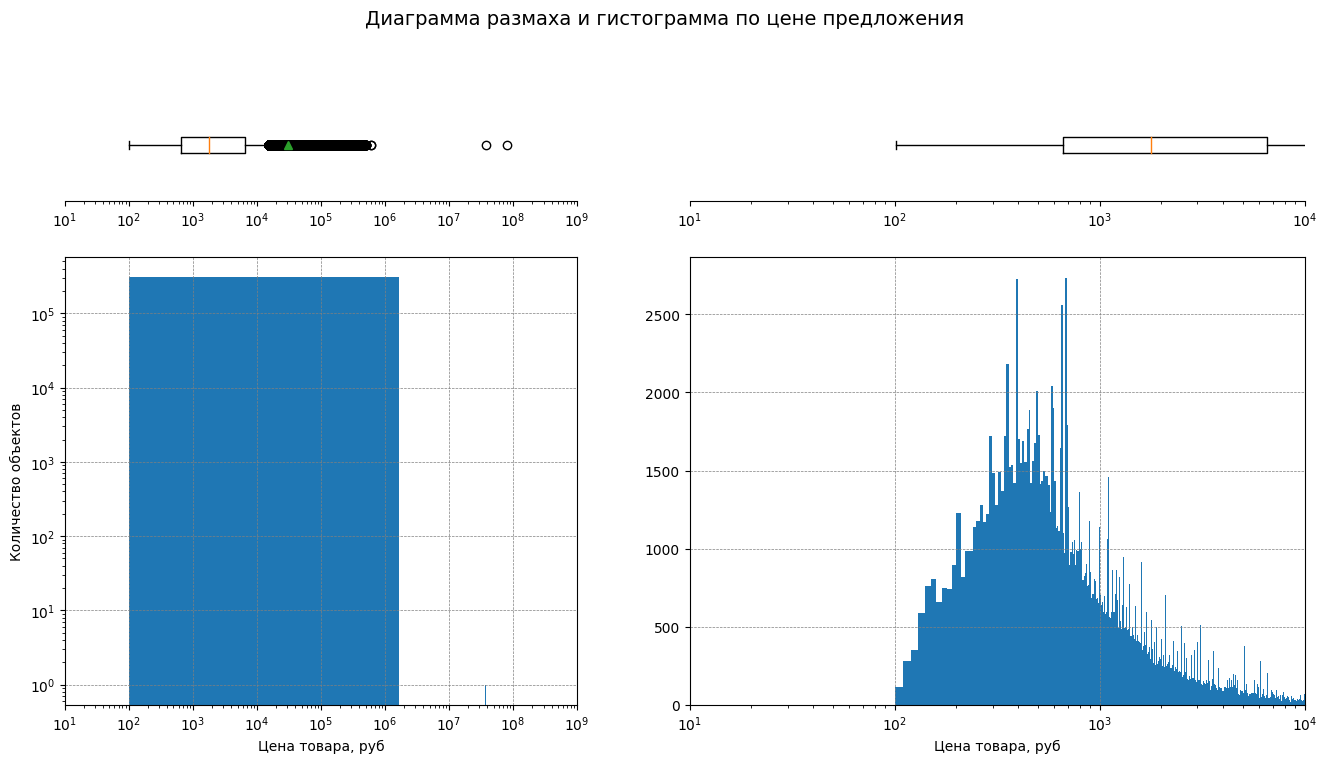

In [63]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку цена в большинстве объектах не превышает 10000 руб, а максимальная цена 1e9 руб,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 1e4 руб.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 8),
    sharex=False,
    gridspec_kw={
        'height_ratios': (.2, .8),
        'width_ratios': (.5, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по цене предложения', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(10,1e9)
ax[1,1].set_xlim(10,1e4)
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,0].set_xlabel('Цена товара, руб')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Цена товара, руб')
# Построим сами диаграммы
ax[1,0].hist(test['goods_price'], bins=1000)
ax[1,1].hist(test['goods_price'], bins=1000, range=(10,1e4))
ax[0,0].boxplot(test[~test['goods_price'].isna()]['goods_price'], vert=False, showmeans=True)
ax[0,1].boxplot(test[~test['goods_price'].isna()]['goods_price'], vert=False, showmeans=True)
plt.show()

Видим, что диапазон цен ориентировочно такой же, как и в обучающей выборке.

In [64]:
# Посмотрим строки, у которых цена предложения выше 500 тыс
test[test['goods_price']>500000]['goods_price'].value_counts()

goods_price
1.638016e+09    3
6.000990e+05    2
1.560016e+09    1
3.750385e+07    1
8.120822e+07    1
Name: count, dtype: int64

In [65]:
test[test['goods_price']>=3.750385e+07].head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
267874,423333,41038,776,0.000038,22560,1.638016e+09,6.0,423333$41038
271688,424740,41073,795,0.001225,6162,1.638016e+09,6.0,424740$41073
303740,424712,1560422,983,0.864258,20690,1.560016e+09,6.0,424712$1560422
311160,423333,842619,1040,0.869141,22560,1.638016e+09,6.0,423333$842619
340883,424710,40865,1315,0.000045,8910,3.750385e+07,6.0,424710$40865


Видим, что значения >3.750385e+07 ошибочные. В дальнейшем учтём это при создании новых признаков.

### Cуммарная длина пары названий и атрибутов в символах

In [66]:
train['sum_length'].describe()

count    2.500000e+06
mean     5.855776e+02
std      4.256947e+02
min      3.700000e+01
25%      2.310000e+02
50%      5.060000e+02
75%      8.040000e+02
max      7.829000e+03
Name: sum_length, dtype: float64

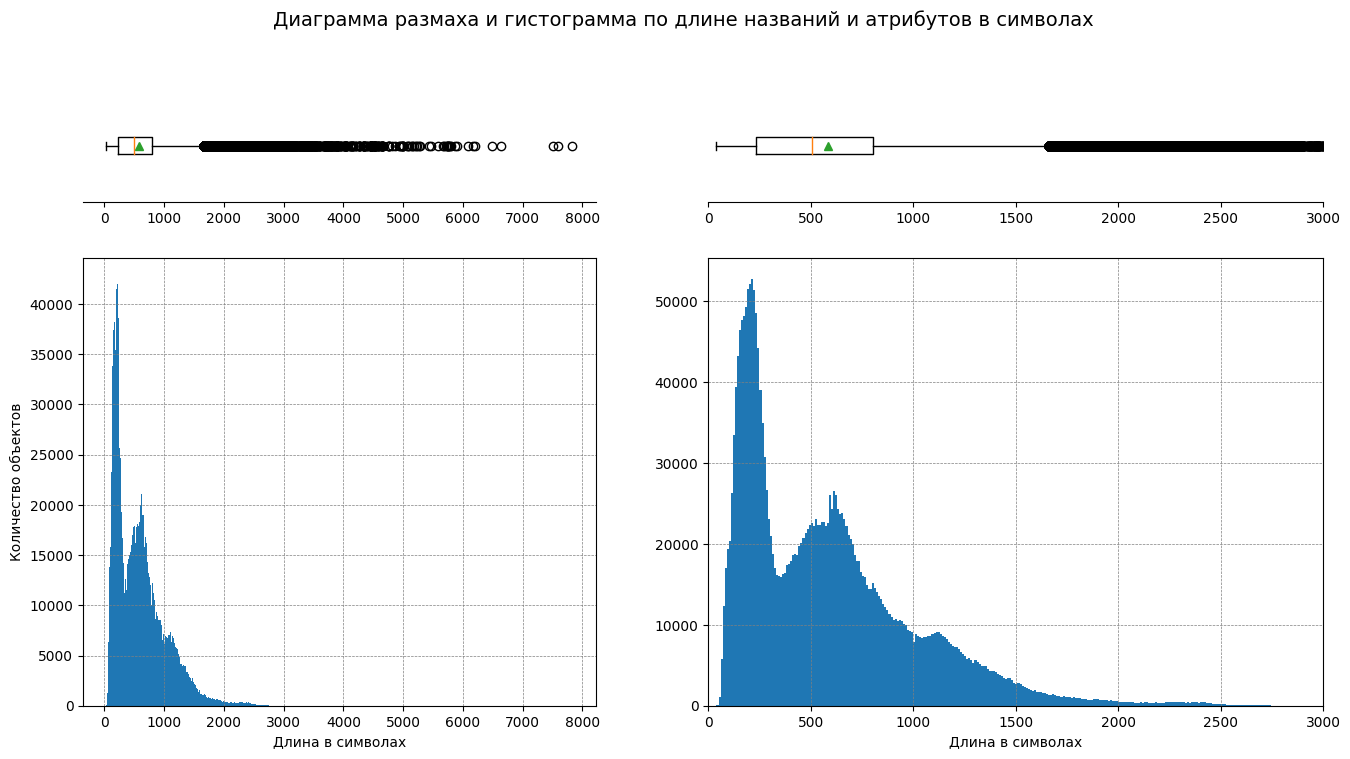

In [67]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку длина в большинстве случаев не превышает 800 символов, а максимум >7 тыс,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 3000 символов.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 8),
    sharex=False,
    gridspec_kw={
        'height_ratios': (.2, .8),
        'width_ratios': (.5, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по длине названий и атрибутов в символах', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1,1].set_xlim(0,3e3)
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,0].set_xlabel('Длина в символах')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Длина в символах')
# Построим сами диаграммы
ax[1,0].hist(train['sum_length'], bins=1000)
ax[1,1].hist(train['sum_length'], bins=1000, range=(10,1e4))
ax[0,0].boxplot(train['sum_length'], vert=False, showmeans=True)
ax[0,1].boxplot(train['sum_length'], vert=False, showmeans=True)
plt.show()

Видим, что в основном длина в символах не более 2500, но редко встречаются и более 5000 символов.

In [68]:
test['sum_length'].describe()

count    363835.000000
mean        583.423703
std         423.870065
min          38.000000
25%         231.000000
50%         504.000000
75%         800.000000
max        6175.000000
Name: sum_length, dtype: float64

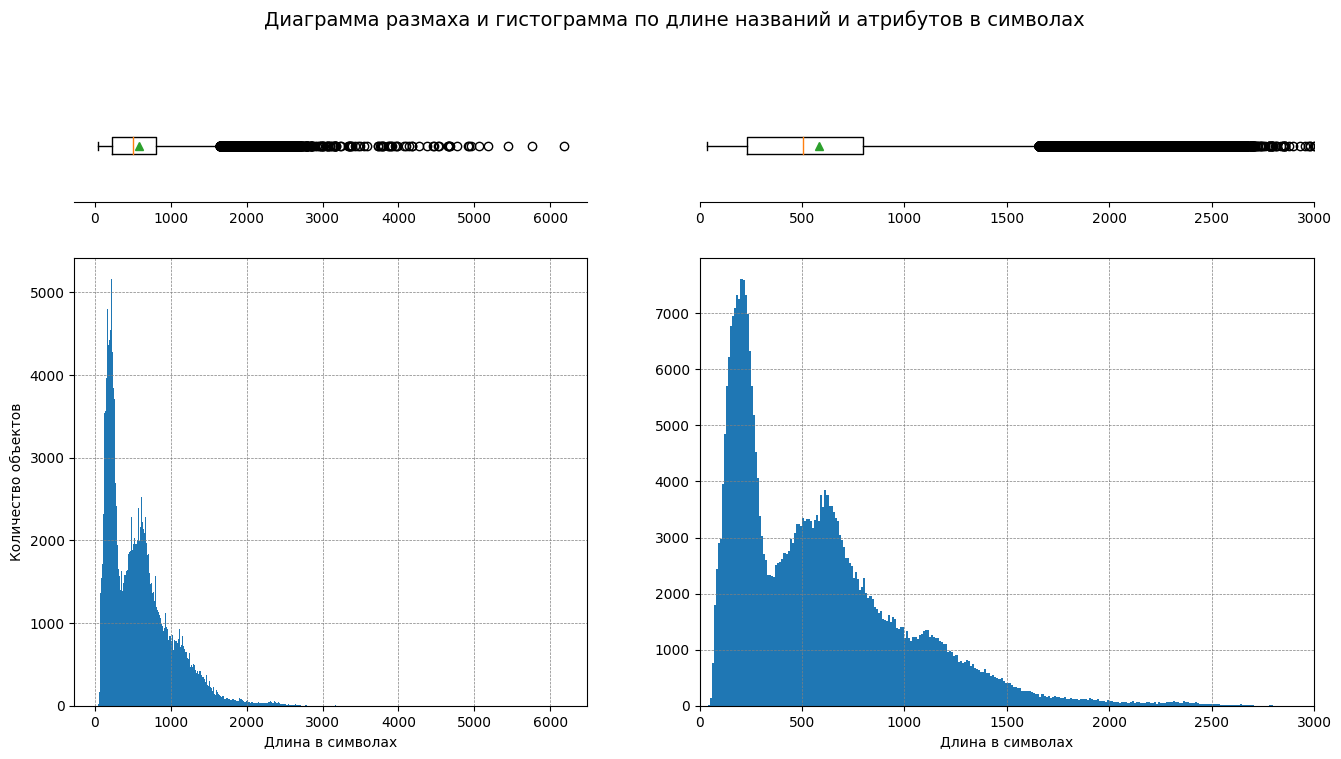

In [69]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку длина в большинстве случаев не превышает 800 символов, а максимум >7 тыс,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 3000 символов.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 8),
    sharex=False,
    gridspec_kw={
        'height_ratios': (.2, .8),
        'width_ratios': (.5, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по длине названий и атрибутов в символах', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1,1].set_xlim(0,3e3)
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,0].set_xlabel('Длина в символах')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Длина в символах')
# Построим сами диаграммы
ax[1,0].hist(test['sum_length'], bins=1000)
ax[1,1].hist(test['sum_length'], bins=1000, range=(10,1e4))
ax[0,0].boxplot(test['sum_length'], vert=False, showmeans=True)
ax[0,1].boxplot(test['sum_length'], vert=False, showmeans=True)
plt.show()

Видим, что распределение в целом совпадает с обучающей выборкой.

### Вероятность матча от рескоринговой модели

In [70]:
train['attrs+title_score'].describe()

count    2.500000e+06
mean     1.286231e-01
std      2.643786e-01
min      3.147125e-05
25%      3.564358e-05
50%      1.063943e-04
75%      5.242920e-02
max      9.975586e-01
Name: attrs+title_score, dtype: float64

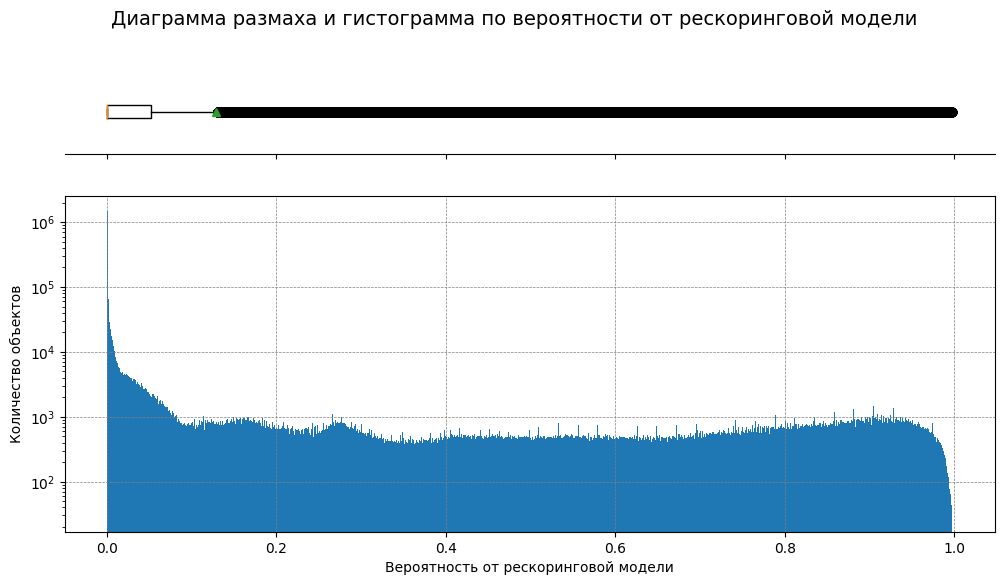

In [71]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=1, nrows=2,
    figsize=(12, 6),
    sharex=True,
    gridspec_kw={
        'height_ratios': (.2, .8)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по вероятности от рескоринговой модели', fontsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1].set_xlabel('Вероятность от рескоринговой модели')
ax[1].set_ylabel('Количество объектов')
ax[1].set_yscale('log')
# Построим сами диаграммы
ax[1].hist(train['attrs+title_score'], bins=1000)
ax[0].boxplot(train['attrs+title_score'], vert=False, showmeans=True)
plt.show()

Видим, что имеется пик в диапазоне до 0,1, а выше 0,1 значения распределены приблизительно равномерно.

In [72]:
test['attrs+title_score'].describe()

count    363835.000000
mean          0.128098
std           0.264238
min           0.000032
25%           0.000035
50%           0.000103
75%           0.050140
max           0.997070
Name: attrs+title_score, dtype: float64

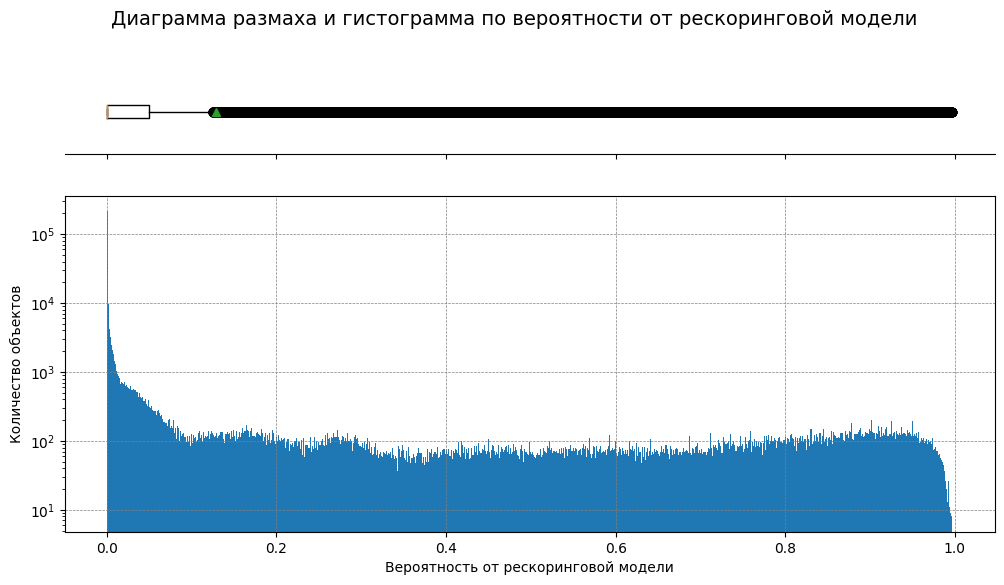

In [73]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=1, nrows=2,
    figsize=(12, 6),
    sharex=True,
    gridspec_kw={
        'height_ratios': (.2, .8)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по вероятности от рескоринговой модели', fontsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1].set_xlabel('Вероятность от рескоринговой модели')
ax[1].set_ylabel('Количество объектов')
ax[1].set_yscale('log')
# Построим сами диаграммы
ax[1].hist(test['attrs+title_score'], bins=1000)
ax[0].boxplot(test['attrs+title_score'], vert=False, showmeans=True)
plt.show()

Видим, что распределение в целом совпадает с обучающей выборкой.

### Категория товара

In [74]:
train['goods_category_id'].value_counts()

goods_category_id
5.000000e+00    460420
6.000000e+00    312322
2.000000e+00    249102
3.000000e+00    195435
1.400000e+01    154753
8.000000e+00    153579
7.000000e+00    149674
8.300000e+01    141020
1.100000e+01    104619
8.200000e+01     97403
4.000000e+00     96048
1.900000e+01     67793
2.100000e+01     67593
8.100000e+01     56111
1.700000e+01     55106
9.000000e+00     50027
1.300000e+01     36697
6.900000e+01     29622
1.800000e+01     16863
2.463685e+15      4980
Name: count, dtype: int64

In [75]:
# Изменим тип на текст, пропуски заполним заглушкой no_info
train['goods_category_id'] = 'cat_' + train['goods_category_id'].astype(str).str[:-2]
train.loc[train['goods_category_id']=='cat_n', 'goods_category_id'] = 'no_info'
train['goods_category_id'].value_counts()

goods_category_id
cat_5                   460420
cat_6                   312322
cat_2                   249102
cat_3                   195435
cat_14                  154753
cat_8                   153579
cat_7                   149674
cat_83                  141020
cat_11                  104619
cat_82                   97403
cat_4                    96048
cat_19                   67793
cat_21                   67593
cat_81                   56111
cat_17                   55106
cat_9                    50027
cat_13                   36697
cat_69                   29622
cat_18                   16863
cat_2463684633817211      4980
no_info                    833
Name: count, dtype: int64

In [76]:
# Аналогично по тестовой выборке
test['goods_category_id'].value_counts()

goods_category_id
5.000000e+00    66720
6.000000e+00    45782
2.000000e+00    36526
3.000000e+00    28179
1.400000e+01    22839
8.000000e+00    22193
7.000000e+00    21705
8.300000e+01    20364
1.100000e+01    15450
4.000000e+00    14126
8.200000e+01    14086
2.100000e+01     9848
1.900000e+01     9765
8.100000e+01     8067
1.700000e+01     8045
9.000000e+00     7101
1.300000e+01     5200
6.900000e+01     4401
1.800000e+01     2554
2.463685e+15      753
Name: count, dtype: int64

In [77]:
# Изменим тип на текст, пропуски заполним заглушкой no_info
test['goods_category_id'] = 'cat_' + test['goods_category_id'].astype(str).str[:-2]
test.loc[test['goods_category_id']=='cat_n', 'goods_category_id'] = 'no_info'
test['goods_category_id'].value_counts()

goods_category_id
cat_5                   66720
cat_6                   45782
cat_2                   36526
cat_3                   28179
cat_14                  22839
cat_8                   22193
cat_7                   21705
cat_83                  20364
cat_11                  15450
cat_4                   14126
cat_82                  14086
cat_21                   9848
cat_19                   9765
cat_81                   8067
cat_17                   8045
cat_9                    7101
cat_13                   5200
cat_69                   4401
cat_18                   2554
cat_2463684633817211      753
no_info                   131
Name: count, dtype: int64

## Создание новых признаков

### Разница цен

In [78]:
# Вычислим отношение цены предложения к цене товара
train['price_ratio'] = train['offer_price']/train['goods_price']

In [79]:
train['price_ratio'].describe()

count    2.095193e+06
mean     4.298296e+02
std      9.144917e+03
min      4.023159e-07
25%      8.777778e-01
50%      1.217125e+00
75%      2.226667e+00
max      9.901000e+05
Name: price_ratio, dtype: float64

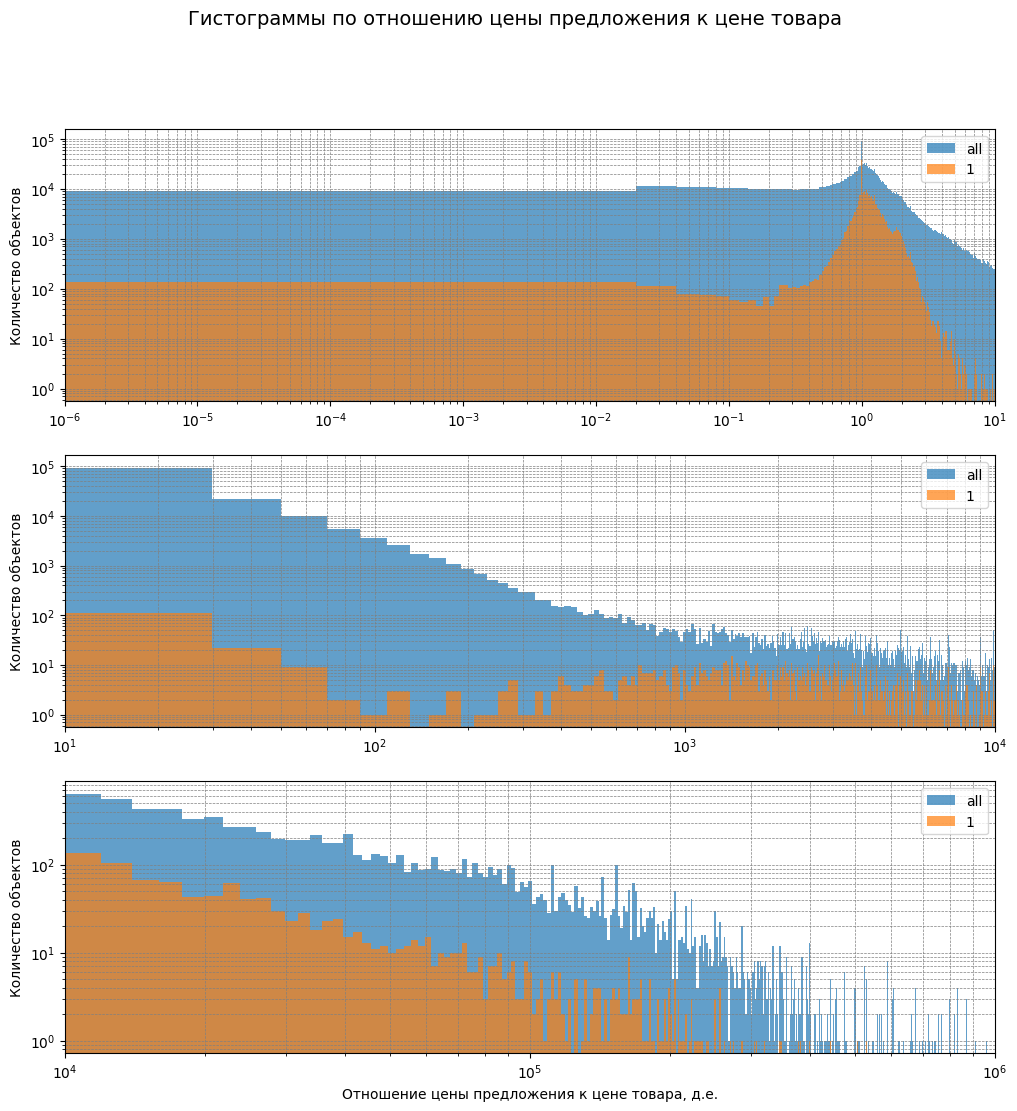

In [80]:
# Посмотрим, как распределеяется отношение цен
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=1, nrows=3,
    figsize=(12, 12),
    sharex=False,
    gridspec_kw={
        'height_ratios': (1/3, 1/3, 1/3)
    }
)
fig.suptitle('Гистограммы по отношению цены предложения к цене товара', fontsize=14)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xlim(1e-6,10)
ax[1].set_xlim(10,1e4)
ax[2].set_xlim(1e4,1e6)
ax[0].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[2].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_ylabel('Количество объектов')
ax[1].set_ylabel('Количество объектов')
ax[2].set_ylabel('Количество объектов')
ax[2].set_xlabel('Отношение цены предложения к цене товара, д.е.')
# Построим сами диаграммы
ax[0].hist(train['price_ratio'],
           bins=500, range=(1e-6,10),
           label='all', alpha=0.7
)
ax[0].hist(
    train[train['target']==1]['price_ratio'],
    bins=500, range=(1e-6,10),
    label='1', alpha=0.7
)
ax[1].hist(train['price_ratio'],
           bins=500, range=(10,1e4),
           label='all', alpha=0.7
)
ax[1].hist(
    train[train['target']==1]['price_ratio'],
    bins=500, range=(10,1e4),
    label='1', alpha=0.7
)
ax[2].hist(train['price_ratio'],
           bins=500, range=(1e4,1e6),
           label='all', alpha=0.7
)
ax[2].hist(
    train[train['target']==1]['price_ratio'],
    bins=500, range=(1e4,1e6),
    label='1', alpha=0.7
)

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [81]:
# Определим функцию для уменьшения разброса значений отношения цены предложения к цене товара
def ratio(price_ratio):
    if price_ratio <= 0.3:
        return 0.15
    for i in range(0, round((0.7-0.3)/0.1)):
        if round(0.3 + i*0.1, 2) < price_ratio <= round(0.3 + (i+1)*0.1, 2):
            return 0.3 + i*0.1 +0.05
    if 0.7 < price_ratio <= 0.9:
        return 0.8
    if 0.9 < price_ratio <= 1.3:
        return 1.1
    for i in range(0, round((1.8-1.3)/0.2)):
        if round(1.3 + i*0.2, 2) < price_ratio <= round(1.3 + (i+1)*0.2, 2):
            return 1.3 + i*0.2 + 0.1
    if 1.8 < price_ratio <= 2.4:
        return 2.1
    for i in range(0, round((3.2-2.4)/0.2)):
        if round(2.4 + i*0.2, 2) < price_ratio <= round(2.4 + (i+1)*0.2, 2):
            return 2.4 + i*0.2 + 0.1    
    if 3.2 < price_ratio <= 10:
        return 6.7
    if 10 < price_ratio <= 200:
        return 105
    for i in range(0, round((1000-200)/100)):
        if round(200 + i*100) < price_ratio <= round(200 + (i+1)*100):
            return 200 + i*100 + 50  
    if 1000 < price_ratio <= 10000:
        return 5500
    for i in range(0, round((100000-10000)/20000)):
        if round(10000 + i*20000) < price_ratio <= round(10000 + (i+1)*20000):
            return 10000 + i*20000  + 10000 
    for i in range(0, round((400000-100000)/100000)):
        if round(100000 + i*100000) < price_ratio <= round(100000 + (i+1)*100000):
            return 100000 + i*100000 + 50000 
    if price_ratio > 400000:
        return 500000

In [82]:
# Пересчитаем отношение цен
train['price_ratio'] = train['price_ratio'].apply(ratio)

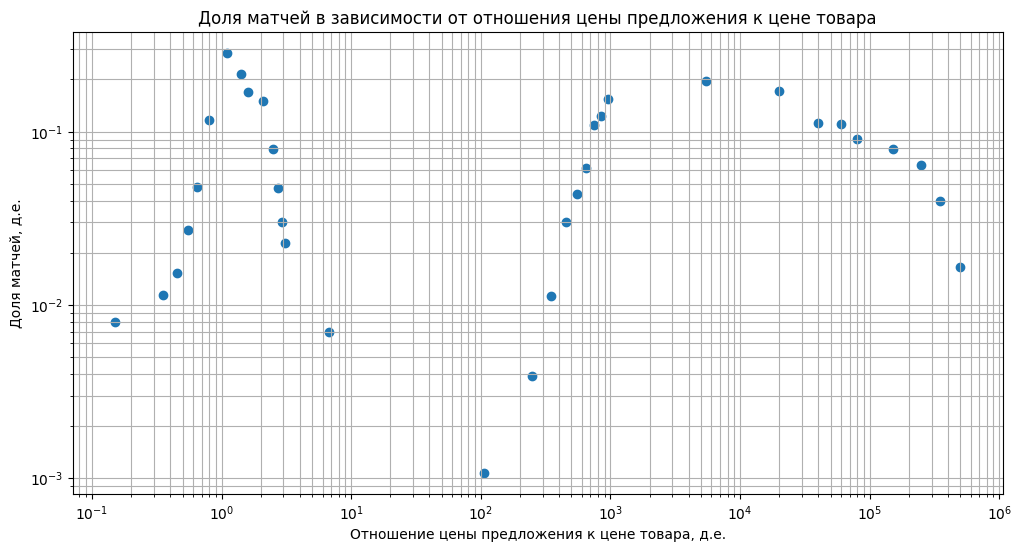

In [83]:
# Сгруппируем данные и построим график
data = train.groupby(['price_ratio'])['target'].agg('mean')
plt.figure(figsize=(12,6))
plt.title('Доля матчей в зависимости от отношения цены предложения к цене товара')
plt.xlabel('Отношение цены предложения к цене товара, д.е.')
plt.ylabel('Доля матчей, д.е.')
plt.grid(which='both')
plt.scatter(data.index, data)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [84]:
# Проверим пропуски
train['price_ratio'].isna().sum()

446559

In [85]:
# Проверим значение таргета для объектов с пропусками
train[train['price_ratio'].isna()]['target'].mean()

0.02509186915950636

In [86]:
# Аналогичная доля матчей имеется при отношении цен
# 0.45, 3.1
# Посмотрим, сколько значений с указанными отношениями имеется
train[train['price_ratio'].isin([0.45, 3.1])]['price_ratio'].value_counts(normalize=True)

price_ratio
0.45    0.725461
3.10    0.274539
Name: proportion, dtype: float64

In [87]:
# Заполним пропуски отношения цен значениями 0.45, 3.1 с учётом частотности
train.loc[train['price_ratio'].isna(), ['price_ratio']] = \
np.random.choice(
    [0.45, 3.1],
    size=train['price_ratio'].isna().sum(),
    replace=True,
    p=[0.725461, 0.274539])
# Проверим пропуски
train['price_ratio'].isna().sum()

0

In [88]:
# Удалим лишние столбцы
train = train.drop(['offer_price', 'goods_price'], axis=1)

In [89]:
# Посмотрим количество пропусков в обучающей выборке
pd.concat(
    [train.isna().sum(), train.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'count', 1: 'part' }
)

,count,part
offer_depersanalised,0,0.0
goods_depersanalised,0,0.0
sum_length,0,0.0
attrs+title_score,0,0.0
goods_category_id,0,0.0
target,0,0.0
id,0,0.0
price_ratio,0,0.0


Аналогично сделаем на тестовой выборке

In [90]:
# Вычислим отличие цены предложения от цены товара
test['price_ratio'] = test['offer_price']/test['goods_price']

In [91]:
test['price_ratio'].describe()

count    304864.000000
mean        454.513086
std        9166.521224
min           0.000004
25%           0.878261
50%           1.218904
75%           2.227978
max      943397.169811
Name: price_ratio, dtype: float64

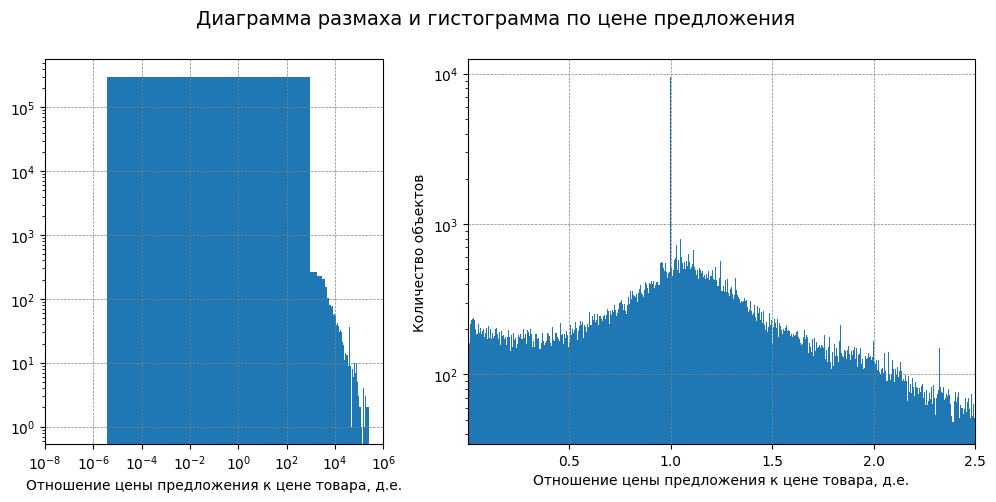

In [92]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку разница в большинстве случаев не превышает 2,5, а максимально 1e6 руб,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон значений, а справа - с ограничением на уровне 2,5.
# Настроим внешний вид области построения
fig, ax = plt.subplots(
    ncols=2, nrows=1,
    figsize=(12, 5),
    sharex=False,
    gridspec_kw={
        'width_ratios': (.4, .6)
    }
)
fig.suptitle('Диаграмма размаха и гистограмма по цене предложения', fontsize=14)
ax[0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(1e-8,1e6)
ax[1].set_xlim(1e-8,2.5)
ax[0].set_xlabel('Отношение цены предложения к цене товара, д.е.')
ax[1].set_ylabel('Количество объектов')
ax[1].set_xlabel('Отношение цены предложения к цене товара, д.е.')
# Построим сами диаграммы
ax[0].hist(test['price_ratio'], bins=1000)
ax[1].hist(test['price_ratio'], bins=1000, range=(1e-8,2.5))
plt.show()

Распределение схоже с обучающей выборкой 

In [93]:
# Применим ту же функцию, что и к обучающей выборке
test['price_ratio'] = test['price_ratio'].apply(ratio)
# Заполним пропуски так же, как и в обучающей выборке
test.loc[test['price_ratio'].isna(), ['price_ratio']] = \
np.random.choice(
    [0.45, 3.1],
    size=test['price_ratio'].isna().sum(),
    replace=True,
    p=[0.725461, 0.274539])
# Проверим пропуски
test['price_ratio'].isna().sum()

0

In [94]:
# Удалим лишние столбцы
test = test.drop(['offer_price', 'goods_price'], axis=1)

In [95]:
# Посмотрим количество пропусков в тестовой выборке
pd.concat(
    [test.isna().sum(), test.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'count', 1: 'part' }
)

,count,part
offer_depersanalised,0,0.0
goods_depersanalised,0,0.0
sum_length,0,0.0
attrs+title_score,0,0.0
goods_category_id,0,0.0
id,0,0.0
price_ratio,0,0.0


### Векторы изображений и текстов

Добавление полных векторов требует слишком много памяти. Вместо этого определим косинусное расстояние между векторами текстов и векторами изображений и добавим результаты в датасет

In [96]:
# Обучающая выборка
# Добавим текстовые векторы для предложений
train = train.merge(offer_titles,
            how='left',
            left_on='offer_depersanalised',
            right_on='otitle_id')
train = train.drop(['otitle_id'], axis=1)

# Добавим текстовые векторы для товаров
train = train.merge(goods_titles,
            how='left',
            left_on='goods_depersanalised',
            right_on='gtitle_id')
train = train.drop(['gtitle_id'], axis=1)
print(f'Размер {train.shape}')
train.head()

Размер (2500000, 136)


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,goods_category_id,target,id,price_ratio,otvec_0,otvec_1,...,gtvec_54,gtvec_55,gtvec_56,gtvec_57,gtvec_58,gtvec_59,gtvec_60,gtvec_61,gtvec_62,gtvec_63
0,295140,1396793,37,0.027267,cat_14,0,295140$1396793,0.45,0.016235,-0.024216,...,0.125977,-0.140137,-0.075256,0.115112,-0.087524,0.011353,0.091858,-0.005070,-0.077942,-0.035126
1,65291,1396586,38,0.050415,cat_14,0,65291$1396586,0.45,0.006058,-0.073059,...,-0.075623,0.165771,0.013565,-0.022964,-0.138550,0.002354,-0.024246,0.043274,0.017319,-0.026962
2,39232,1396244,38,0.087280,cat_14,0,39232$1396244,3.10,-0.000360,-0.085999,...,-0.088501,0.081177,-0.000949,0.057892,0.044617,0.085999,0.018280,-0.070251,-0.065735,-0.090393
3,39232,1396513,38,0.087280,cat_14,0,39232$1396513,0.45,-0.000360,-0.085999,...,-0.001879,-0.000826,0.074341,-0.013405,0.123962,0.114380,-0.004498,0.122314,-0.015778,0.091431
4,65052,1396237,38,0.079773,cat_14,0,65052$1396237,0.45,0.023895,-0.024185,...,0.063171,0.113586,-0.008308,-0.029938,-0.004616,0.096497,0.036957,-0.100281,-0.013535,-0.131104


In [97]:
# Рассчитаем косинусное расстояние между векторами текстов
cosine_dist = paired_cosine_distances(train.iloc[:, 8:72], train.iloc[:, 72:136])
train_text_embs = train.iloc[:, 8:].values
train = train.iloc[:, :8]
train['text_cos_dist'] = cosine_dist

In [98]:
# Добавим векторы изображений для предложений
train = train.merge(offer_imgs,
            how='left',
            left_on='offer_depersanalised',
            right_on='oimg_id')
train = train.drop(['oimg_id'], axis=1)

# Добавим векторы изображений для товаров
train = train.merge(goods_imgs,
            how='left',
            left_on='goods_depersanalised',
            right_on='gimg_id')
train = train.drop(['gimg_id'], axis=1)
print(f'Размер {train.shape}')
train.head()

Размер (2500000, 521)


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,goods_category_id,target,id,price_ratio,text_cos_dist,oimvec_0,...,gimvec_246,gimvec_247,gimvec_248,gimvec_249,gimvec_250,gimvec_251,gimvec_252,gimvec_253,gimvec_254,gimvec_255
0,295140,1396793,37,0.027267,cat_14,0,295140$1396793,0.45,0.922449,-2.292969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65291,1396586,38,0.050415,cat_14,0,65291$1396586,0.45,1.012589,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39232,1396244,38,0.087280,cat_14,0,39232$1396244,3.10,1.092065,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39232,1396513,38,0.087280,cat_14,0,39232$1396513,0.45,1.103111,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,65052,1396237,38,0.079773,cat_14,0,65052$1396237,0.45,0.922217,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# Проверим, имеются ли в векторах изображений нулевые значения
# Для предложений
print(
    f'Нулевых значений в векторах изображений (предложения) {(train.iloc[:,9:9+256]==0).sum().sum()}'
)
# Для товаров
print(
    f'Нулевых значений в векторах изображений (товары) {(train.iloc[:,9+256:]==0).sum().sum()}'
)

Нулевых значений в векторах изображений (предложения) 0
Нулевых значений в векторах изображений (товары) 0


In [100]:
# Заполним пропуски в векторах изображений заглушкой (нулями)
# Выполнять операцию будем батчами по несклько столбцов из-за ограничений по памяти
batch_size = 16
for i in range(16):
    train.iloc[:,9+i*batch_size:9+(i+1)*batch_size] = \
    train.iloc[:,9+i*batch_size:9+(i+1)*batch_size].fillna(0)
    gc.collect()
train.iloc[:,9:9+256].isna().sum().sum()

0

In [101]:
# То же для векторов изображений товаров
for i in range(16):
    train.iloc[:,9+256+i*batch_size:9+256+(i+1)*batch_size] = \
    train.iloc[:,9+256+i*batch_size:9+256+(i+1)*batch_size].fillna(0)
    gc.collect()
train.iloc[:,9+256:].isna().sum().sum()

0

In [102]:
# Рассчитаем косинусное расстояние между векторами изображений
cosine_dist = []
batch_size = 5000
for i in range(round(np.ceil(train.shape[0]/batch_size))):
    cosine_dist.append(
    paired_cosine_distances(
        train.iloc[i*batch_size:(i+1)*batch_size, 9:265],
        train.iloc[i*batch_size:(i+1)*batch_size, 265:]
    )
    )
train_img_embs = train.iloc[:, 9:].values 
train = train.iloc[:, :9]
train['img_cos_dist'] = np.concatenate(cosine_dist, axis=None)

In [103]:
# удалим лишние столбцы
train = train.drop(['offer_depersanalised', 'goods_depersanalised'], axis=1)

In [104]:
# Уменьшим размерность признаков
train['attrs+title_score'] = train['attrs+title_score'].astype('float32')
train['text_cos_dist'] = train['text_cos_dist'].astype('float32')
train['price_ratio'] = train['price_ratio'].astype('float32')
train['sum_length'] = train['sum_length'].astype('int32')
train['target'] = train['target'].astype('int32')

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sum_length         int32  
 1   attrs+title_score  float32
 2   goods_category_id  object 
 3   target             int32  
 4   id                 object 
 5   price_ratio        float32
 6   text_cos_dist      float32
 7   img_cos_dist       float32
dtypes: float32(4), int32(2), object(2)
memory usage: 95.4+ MB


In [106]:
# Тестовая выборка
# Добавим текстовые векторы для предложений
test = test.merge(offer_titles,
            how='left',
            left_on='offer_depersanalised',
            right_on='otitle_id')
test = test.drop(['otitle_id'], axis=1)

# Добавим текстовые векторы для товаров
test = test.merge(goods_titles,
            how='left',
            left_on='goods_depersanalised',
            right_on='gtitle_id')
test = test.drop(['gtitle_id'], axis=1)
print(f'Размер {test.shape}')
test.head()

Размер (363835, 135)


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,goods_category_id,id,price_ratio,otvec_0,otvec_1,otvec_2,...,gtvec_54,gtvec_55,gtvec_56,gtvec_57,gtvec_58,gtvec_59,gtvec_60,gtvec_61,gtvec_62,gtvec_63
0,64819,1396468,38,0.046997,cat_14,64819$1396468,0.45,0.012001,-0.017517,-0.058380,...,-0.051971,0.001155,-0.034210,0.144165,0.101074,0.007835,0.012848,0.068115,0.039764,0.151855
1,64819,1396235,38,0.046997,cat_14,64819$1396235,0.45,0.012001,-0.017517,-0.058380,...,-0.038971,0.043396,0.011642,0.088684,0.030945,-0.119019,-0.024979,-0.173096,0.109375,0.079163
2,64819,1396318,38,0.046997,cat_14,64819$1396318,0.45,0.012001,-0.017517,-0.058380,...,0.013390,0.164795,-0.034851,0.100830,-0.073730,-0.074463,-0.008080,0.038116,0.016052,0.104187
3,359959,1396281,40,0.060211,cat_14,359959$1396281,0.45,0.064575,0.059814,0.047943,...,0.045837,0.199219,-0.148804,-0.073547,-0.056213,-0.112732,-0.049927,0.039917,0.001406,-0.119751
4,142700,717657,40,0.000370,cat_2,142700$717657,0.45,0.089417,-0.110413,0.040161,...,0.113770,-0.153564,0.087097,0.178589,-0.128174,0.013962,0.112549,0.109253,-0.134766,0.034851


In [107]:
# Рассчитаем косинусное расстояние между векторами текстов
cosine_dist = paired_cosine_distances(test.iloc[:, 7:71], test.iloc[:, 71:])
test_text_embs = test.iloc[:, 7:].values
test = test.iloc[:, :7]
test['text_cos_dist'] = cosine_dist

In [108]:
# Добавим векторы изображений для предложений
test = test.merge(offer_imgs,
            how='left',
            left_on='offer_depersanalised',
            right_on='oimg_id')
test = test.drop(['oimg_id'], axis=1)

# Добавим векторы изображений для товаров
test = test.merge(goods_imgs,
            how='left',
            left_on='goods_depersanalised',
            right_on='gimg_id')
test = test.drop(['gimg_id'], axis=1)
print(f'Размер {test.shape}')
test.head()

Размер (363835, 520)


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,goods_category_id,id,price_ratio,text_cos_dist,oimvec_0,oimvec_1,...,gimvec_246,gimvec_247,gimvec_248,gimvec_249,gimvec_250,gimvec_251,gimvec_252,gimvec_253,gimvec_254,gimvec_255
0,64819,1396468,38,0.046997,cat_14,64819$1396468,0.45,0.962683,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64819,1396235,38,0.046997,cat_14,64819$1396235,0.45,1.042312,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64819,1396318,38,0.046997,cat_14,64819$1396318,0.45,1.176345,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,359959,1396281,40,0.060211,cat_14,359959$1396281,0.45,0.998460,0.299072,0.111206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,142700,717657,40,0.000370,cat_2,142700$717657,0.45,1.073020,1.399414,0.749023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
# Освободим память
del offer_titles, offer_imgs, goods_titles, goods_imgs
gc.collect()

0

In [110]:
# Аналогично для тестовой выборки
# Проверим, имеются ли в векторах изображений нулевые значения
# Для предложений
print(
    f'Нулевых значений в векторах изображений (предложения) {(test.iloc[:,8:8+256]==0).sum().sum()}'
)
# Для товаров
print(
    f'Нулевых значений в векторах изображений (товары) {(test.iloc[:,8+256:]==0).sum().sum()}'
)

Нулевых значений в векторах изображений (предложения) 0
Нулевых значений в векторах изображений (товары) 0


In [111]:
# Заполним пропуски в векторах изображений заглушкой (нулями)
batch_size = 16
for i in range(16):
    test.iloc[:,8+i*batch_size:8+(i+1)*batch_size] = \
    test.iloc[:,8+i*batch_size:8+(i+1)*batch_size].fillna(0)
    gc.collect()
test.iloc[:,8:8+256].isna().sum().sum()

0

In [112]:
# То же для векторов изображений товаров
for i in range(16):
    test.iloc[:,8+256+i*batch_size:8+256+(i+1)*batch_size] = \
    test.iloc[:,8+256+i*batch_size:8+256+(i+1)*batch_size].fillna(0)
    gc.collect()
test.iloc[:,8+256:].isna().sum().sum()

0

In [113]:
# удалим лишние столбцы
test = test.drop(['offer_depersanalised', 'goods_depersanalised'], axis=1)

In [114]:
# Рассчитаем косинусное расстояние между векторами изображений
cosine_dist = []
batch_size = 5000
for i in range(round(np.ceil(test.shape[0]/batch_size))):
    cosine_dist.append(
    paired_cosine_distances(
        test.iloc[i*batch_size:(i+1)*batch_size, 6:262],
        test.iloc[i*batch_size:(i+1)*batch_size, 262:]
    )
    )
test_img_embs = test.iloc[:, 6:].values  
test = test.iloc[:, :6]
test['img_cos_dist'] = np.concatenate(cosine_dist, axis=None)

In [115]:
# Уменьшим размерность признаков
test['attrs+title_score'] = train['attrs+title_score'].astype('float32')
test['text_cos_dist'] = train['text_cos_dist'].astype('float32')
test['price_ratio'] = train['price_ratio'].astype('float32')
test['sum_length'] = train['sum_length'].astype('int32')

In [116]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sum_length         363835 non-null  int32  
 1   attrs+title_score  363835 non-null  float32
 2   goods_category_id  363835 non-null  object 
 3   id                 363835 non-null  object 
 4   price_ratio        363835 non-null  float32
 5   text_cos_dist      363835 non-null  float32
 6   img_cos_dist       363835 non-null  float32
dtypes: float32(4), int32(1), object(2)
memory usage: 12.5+ MB


In [117]:
# Уберём лишние столбцы с id пары, которые не требуются для обучения
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

In [118]:
# Сохраним результаты работы в файлы
train.to_csv('train_no_embs.csv', index=False)
np.save('train_no_embs.npy', train.values, allow_pickle=True, fix_imports=False)
test.to_csv('test_no_embs.csv', index=False)
np.save('test_no_embs.npy', test.values, allow_pickle=True, fix_imports=False)
np.save('train_text_embs.npy', train_text_embs, allow_pickle=False, fix_imports=False)
np.save('train_img_embs.npy', train_img_embs, allow_pickle=False, fix_imports=False)
np.save('test_text_embs.npy', test_text_embs, allow_pickle=False, fix_imports=False)
np.save('test_img_embs.npy', test_img_embs, allow_pickle=False, fix_imports=False)

## Подготовка набора данных для моделирования

In [3]:
train = pd.read_csv('train_no_embs.csv')
test = pd.read_csv('test_no_embs.csv')

In [4]:
# Разделим признаки
X = ['sum_length',
     'attrs+title_score',
     'goods_category_id',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]
y = ['target']

In [5]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['goods_category_id']

In [6]:
# Составим список числовых признаков
num_features = (
    train[X]
    .select_dtypes(include=['int32', 'float32', 'int64', 'float64'])
    .columns.to_list()
)
num_features

['sum_length',
 'attrs+title_score',
 'text_cos_dist',
 'img_cos_dist',
 'price_ratio']

In [7]:
# Определим собственный scorer для оценки качества и выбора модели
def f1_max_score(clf, y, val_data):    
    # Вычислим максимальное значение f1
    # Вычислим значения precision и recall при всех порогах
    precision, recall, thresholds = precision_recall_curve(
        y, clf.predict_proba(val_data)[:, 1]
    )
    # Вычислим значения f1 при всех порогах в обозначенном диапазоне
    f1_scores = 2*recall*precision/(recall + precision)
    # Максимальное значение f1
    return np.max(f1_scores)

In [8]:
# Для выбора модели разделим обучающую выборку на обучающую и валидационную
X_train, X_val, y_train, y_val = train_test_split(
    train[X], train[y],
    test_size=0.2, stratify=train[y]
)

## Обучение моделей

### Catboost

Для решения задачи воспользуемся моделью на основе градиентного бустинга (библиотека catboost). Будем выбирать модель с максимальным значением метрики AUC под ROC кривой.

#### Без признаков на основе векторов текстов и изображений

In [9]:
# Данные для модели
train_data = Pool(
    data=FeaturesData(
        num_feature_data=X_train[num_features].values.astype('float32'),
        cat_feature_data=X_train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_train.values
)
val_data = Pool(
    data=FeaturesData(
        num_feature_data=X_val[num_features].values.astype('float32'),
        cat_feature_data=X_val[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_val.values
)

Перебором гиперпараметров:
- depth максимальная глубина дерева из списка значений [6, 8, 10, 12, 13, 16],
- learning_rate шаг обучения из списка значений [0.001, 0.03, 0.05, 0.1, 0.3],
- iterations число деревьев в ансамбле из списка значений [450, 1000, 2000],
- auto_class_weights из списка значений ['Balanced', None],
- task_type из списка значений ['GPU', 'CPU'],
определим модель с наилучшим значением метрики.

In [10]:
# Модель
cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,          
    depth=12,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    logging_level='Silent',
    task_type='GPU'
)

In [11]:
cb.fit(
    train_data,
    eval_set=val_data,
    plot=True,
    baseline=None,
    early_stopping_rounds=5,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [13]:
# Посчитаем максимальное значение f1 на валидационной выборке
f1_max_score(cb, y_val, val_data)

0.8628296254479827

Качество модели низкое. Добавим дополнительные признаки на основе векторов изображений и текстов.

#### Из текстов - 16 , из изображений - 16 признаков 

In [15]:
# Добавим эмбеддинги в датасет для повышения качества
# Загрузим ранее сохранённые эмбеддинги обучающей выборки
train_text_embs = np.load('train_text_embs.npy', allow_pickle=False)
train_img_embs = np.load('train_img_embs.npy', allow_pickle=False)

In [16]:
# Уменьшим размерность эмбеддингов, усредняя каждые 8 элементов текстовых веткоров
m = 8
train_text_embs = \
train_text_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(train_text_embs.shape[1]/m))
# и каждые 32 элемента векторов изображения
m = 32
train_img_embs = \
train_img_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(train_img_embs.shape[1]/m))

In [18]:
# Объединим данные для обучения
# Наименования признаков
columns = list(train.columns) + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,16)]
train = pd.DataFrame(
    np.concatenate(
        (train.values, train_text_embs, train_img_embs),
        axis=1
    ),
    columns = columns
)
train['target'] = train['target'].astype('int32')
train[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,16)]] = \
train[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,16)]].astype('float32')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 39 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sum_length         float32
 1   attrs+title_score  float32
 2   goods_category_id  object 
 3   target             int32  
 4   price_ratio        float32
 5   text_cos_dist      float32
 6   img_cos_dist       float32
 7   t_emb0             float32
 8   t_emb1             float32
 9   t_emb2             float32
 10  t_emb3             float32
 11  t_emb4             float32
 12  t_emb5             float32
 13  t_emb6             float32
 14  t_emb7             float32
 15  t_emb8             float32
 16  t_emb9             float32
 17  t_emb10            float32
 18  t_emb11            float32
 19  t_emb12            float32
 20  t_emb13            float32
 21  t_emb14            float32
 22  t_emb15            float32
 23  im_emb0            float32
 24  im_emb1            float32
 25  im_emb2           

In [19]:
# Разделим признаки
X = ['sum_length',
     'attrs+title_score',
     'goods_category_id',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
] + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,16)]
y = ['target']

In [20]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['goods_category_id']

In [21]:
# Составим список числовых признаков
num_features = (
    train[X]
    .select_dtypes(include=['int32', 'float32', 'int64', 'float64'])
    .columns.to_list()
)
num_features

['sum_length',
 'attrs+title_score',
 'text_cos_dist',
 'img_cos_dist',
 'price_ratio',
 't_emb0',
 't_emb1',
 't_emb2',
 't_emb3',
 't_emb4',
 't_emb5',
 't_emb6',
 't_emb7',
 't_emb8',
 't_emb9',
 't_emb10',
 't_emb11',
 't_emb12',
 't_emb13',
 't_emb14',
 't_emb15',
 'im_emb0',
 'im_emb1',
 'im_emb2',
 'im_emb3',
 'im_emb4',
 'im_emb5',
 'im_emb6',
 'im_emb7',
 'im_emb8',
 'im_emb9',
 'im_emb10',
 'im_emb11',
 'im_emb12',
 'im_emb13',
 'im_emb14',
 'im_emb15']

In [22]:
# Загрузим ранее сохранённые эмбеддинги тестовой выборки
test_text_embs = np.load('test_text_embs.npy', allow_pickle=False)
test_img_embs = np.load('test_img_embs.npy', allow_pickle=False)

In [23]:
# Уменьшим размерность эмбеддингов, усредняя каждые 8 элементов текстовых веткоров
m = 8
test_text_embs = \
test_text_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(test_text_embs.shape[1]/m))
# и каждые 32 элемента векторов изображения
m = 32
test_img_embs = \
test_img_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(test_img_embs.shape[1]/m))

In [24]:
# Объединим данные для обучения
# Наименования признаков
columns = list(test.columns) + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,16)]
test = pd.DataFrame(
    np.concatenate(
        (test.values, test_text_embs, test_img_embs),
        axis=1
    ),
    columns = columns
)
test[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,16)]] = \
test[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,16)]].astype('float32')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sum_length         363835 non-null  float32
 1   attrs+title_score  363835 non-null  float32
 2   goods_category_id  363835 non-null  object 
 3   price_ratio        363835 non-null  float32
 4   text_cos_dist      363835 non-null  float32
 5   img_cos_dist       363835 non-null  float32
 6   t_emb0             363835 non-null  float32
 7   t_emb1             363835 non-null  float32
 8   t_emb2             363835 non-null  float32
 9   t_emb3             363835 non-null  float32
 10  t_emb4             363835 non-null  float32
 11  t_emb5             363835 non-null  float32
 12  t_emb6             363835 non-null  float32
 13  t_emb7             363835 non-null  float32
 14  t_emb8             363835 non-null  float32
 15  t_emb9             363835 non-null  float32
 16  t_

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    train[X], train[y],
    test_size=0.2, stratify=train[y]
)

In [26]:
# Данные для модели
train_data = Pool(
    data=FeaturesData(
        num_feature_data=X_train[num_features].values.astype('float32'),
        cat_feature_data=X_train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_train.values
)
val_data = Pool(
    data=FeaturesData(
        num_feature_data=X_val[num_features].values.astype('float32'),
        cat_feature_data=X_val[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_val.values
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=test[num_features].values.astype('float32'),
        cat_feature_data=test[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    )
)

Перебором гиперпараметров:
- depth максимальная глубина дерева из списка значений [6, 8, 10, 12, 13, 16],
- learning_rate шаг обучения из списка значений [0.001, 0.03, 0.05, 0.1, 0.3],
- iterations число деревьев в ансамбле из списка значений [450, 1000, 2000],
- auto_class_weights из списка значений ['Balanced', None],
- task_type из списка значений ['GPU', 'CPU'],
определим модель с наилучшим значением метрики.

In [27]:
# Модель
cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,          
    depth=12,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    logging_level='Silent',
    task_type='GPU'
)

In [28]:
cb.fit(
    train_data,
    eval_set=val_data,
    plot=True,
    baseline=None,
    early_stopping_rounds=20,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [29]:
# Посчитаем максимальное значение f1 на валидационной выборке
f1_max_score(cb, y_val, val_data)

0.9221890547263683

In [30]:
# Вычислим предсказания при максимальном значении f1
# Вычислим значения precision и recall при всех порогах
precision, recall, thresholds = precision_recall_curve(
    y_val, cb.predict_proba(val_data)[:, 1]
)
# Вычислим значения f1 при всех порогах в обозначенном диапазоне
f1_scores = 2*recall*precision/(recall + precision)
th_for_max = thresholds[np.argmax(f1_scores)]
# Максимальное значение f1 на валидационной выборке
print(f'f1 max {np.max(f1_scores)}')

f1 max 0.9221890547263683


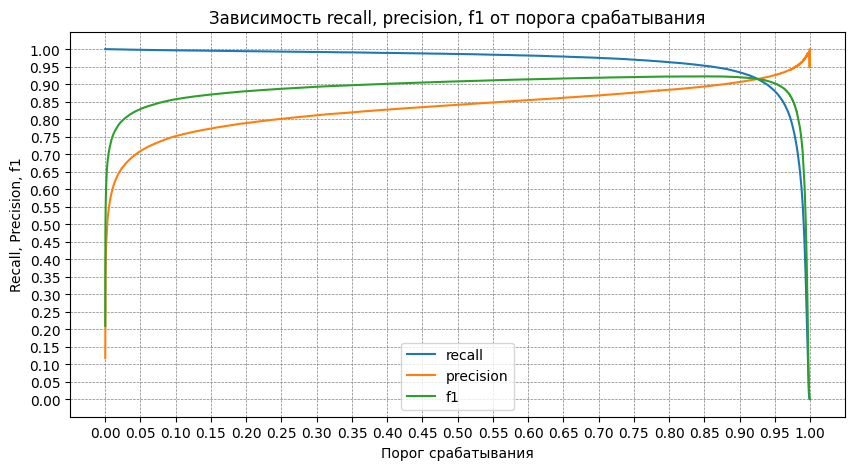

In [31]:
plt.figure(figsize=(10,5))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.title('Зависимость recall, precision, f1 от порога срабатывания')
plt.xticks(np.arange(0,1.05,0.05))
plt.yticks(np.arange(0,1.05,0.05))
plt.xlabel('Порог срабатывания')
plt.ylabel('Recall, Precision, f1')
plt.plot(np.concatenate(([0], thresholds), axis=None), recall, label='recall')
plt.plot(np.concatenate(([0], thresholds), axis=None), precision, label='precision')
plt.plot(np.concatenate(([0], thresholds), axis=None), f1_scores, label='f1')
plt.legend()
plt.show()

In [32]:
# Обучим модель на всей обучающей выборке
train_data = Pool(
    data=FeaturesData(
        num_feature_data=train[num_features].values.astype('float32'),
        cat_feature_data=train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=train[y].values
)

In [33]:
# Модель
cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,          
    depth=12,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    logging_level='Silent',
    task_type='GPU'
)

In [34]:
cb.fit(
    train_data,
    plot=True,
    baseline=None
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
# Вычислим предсказания при максимальном значении f1
# Вычислим значения precision и recall при всех порогах
precision, recall, thresholds = precision_recall_curve(
    train[y], cb.predict_proba(train_data)[:, 1]
)
# Вычислим значения f1 при всех порогах в обозначенном диапазоне
f1_scores = 2*recall*precision/(recall + precision)
th_for_max = thresholds[np.argmax(f1_scores)]
# Максимальное значение f1 на обучающей выборке
print(f'f1 max {np.max(f1_scores)}')

f1 max 0.9446139477475128


In [87]:
# Предсказания модели с вычисленным порогом
pred = (cb.predict_proba(test_data)[:, 1]>th_for_max).astype(int)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv('submission_13 gpu new price_dif t16 im16 1000-0.03-12 0.9446.csv', index=False)

In [36]:
# Сохраним значения, на которых модель закончила обучение,
# выходы модели перед применением сигмоиды
raw_vals = cb.predict(
    data=train_data,
    prediction_type='RawFormulaVal'
)
np.save('baseline_0.npy', raw_vals, allow_pickle=False, fix_imports=False)
raw_vals.shape

(2500000,)

In [91]:
# сохраним модель
with open('best_model_0.pkl','wb') as f:
    pickle.dump(cb, f)
# Загрузить
# with open('model.pkl', 'rb') as f:
#    clf = pickle.load(f)

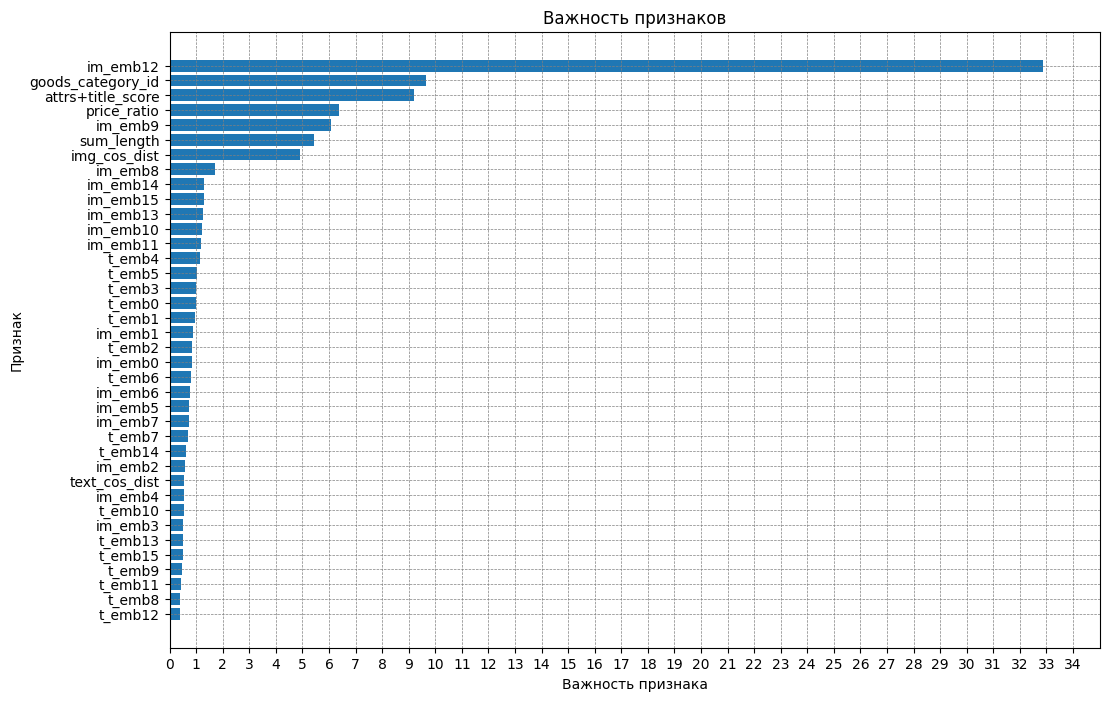

In [37]:
# Проверим важность признаков с точки зрения модели
importances = pd.Series(
    cb.feature_importances_,
    index=cb.feature_names_).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.xlim([0, 35])
plt.xticks(np.arange(0, 35, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index[::-1], width=importances[::-1])
plt.show()

#### Из текстов - 16 , из изображений - 29 признаков 

Те компоненты векторов изображений, которые оказались важными для модели, выделим более подробно, увеличив размерность векторов за счёт наиболее важных компонентов.

In [2]:
train = pd.read_csv('train_no_embs.csv')
test = pd.read_csv('test_no_embs.csv')

In [3]:
# Добавим эмбеддинги в датасет для повышения качества
# Загрузим ранее сохранённые эмбеддинги обучающей выборки
train_text_embs = np.load('train_text_embs.npy', allow_pickle=False)
train_img_embs = np.load('train_img_embs.npy', allow_pickle=False)

In [4]:
# Уменьшим размерность эмбеддингов, усредняя каждые 8 элементов текстовых веткоров
m = 8
train_text_embs = \
train_text_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(train_text_embs.shape[1]/m))
# и для векторов изображения
# каждые 32 элемента для разрядов 0-127
# каждые 16 элементов для разрядов 128-159
# каждые 32 элементов для разрядов 160-255
# каждые 16 элемента для разрядов 256-287
# каждые 8 элементов для разрядов 288-319
# каждые 16 элемента для разрядов 320-383
# каждые 8 элементов для разрядов 384-415
# каждые 16 элементов для разрядов 416-511
train_img_embs = \
np.concatenate(
 (train_img_embs[:,:128].reshape(-1, 32).mean(axis=1).reshape(-1, int(train_img_embs[:,:128].shape[1]/32)),
 train_img_embs[:,128:160].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,128:160].shape[1]/16)),
 train_img_embs[:,160:256].reshape(-1, 32).mean(axis=1).reshape(-1, int(train_img_embs[:,160:256].shape[1]/32)),
 train_img_embs[:,256:288].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,256:288].shape[1]/16)),
 train_img_embs[:,288:320].reshape(-1, 8).mean(axis=1).reshape(-1, int(train_img_embs[:,288:320].shape[1]/8)),
 train_img_embs[:,320:384].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,320:384].shape[1]/16)), 
 train_img_embs[:,384:416].reshape(-1, 8).mean(axis=1).reshape(-1, int(train_img_embs[:,384:416].shape[1]/8)),
 train_img_embs[:,416:].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,416:].shape[1]/16))),
  axis=1
)
train_text_embs.shape, train_img_embs.shape

((2500000, 16), (2500000, 29))

In [5]:
# Объединим данные для обучения
# Наименования признаков
columns = list(train.columns) + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,29)]
train = pd.DataFrame(
    np.concatenate(
        (train.values, train_text_embs, train_img_embs),
        axis=1
    ),
    columns = columns
)
train['target'] = train['target'].astype('int32')
train[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,29)]] = \
train[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,29)]].astype('float32')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 52 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sum_length         float32
 1   attrs+title_score  float32
 2   goods_category_id  object 
 3   target             int32  
 4   price_ratio        float32
 5   text_cos_dist      float32
 6   img_cos_dist       float32
 7   t_emb0             float32
 8   t_emb1             float32
 9   t_emb2             float32
 10  t_emb3             float32
 11  t_emb4             float32
 12  t_emb5             float32
 13  t_emb6             float32
 14  t_emb7             float32
 15  t_emb8             float32
 16  t_emb9             float32
 17  t_emb10            float32
 18  t_emb11            float32
 19  t_emb12            float32
 20  t_emb13            float32
 21  t_emb14            float32
 22  t_emb15            float32
 23  im_emb0            float32
 24  im_emb1            float32
 25  im_emb2           

In [6]:
# Разделим признаки
X = ['sum_length',
     'attrs+title_score',
     'goods_category_id',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
] + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,29)]
y = ['target']

In [7]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['goods_category_id']

In [8]:
# Составим список числовых признаков
num_features = (
    train[X]
    .select_dtypes(include=['int32', 'float32', 'int64', 'float64'])
    .columns.to_list()
)
num_features

['sum_length',
 'attrs+title_score',
 'text_cos_dist',
 'img_cos_dist',
 'price_ratio',
 't_emb0',
 't_emb1',
 't_emb2',
 't_emb3',
 't_emb4',
 't_emb5',
 't_emb6',
 't_emb7',
 't_emb8',
 't_emb9',
 't_emb10',
 't_emb11',
 't_emb12',
 't_emb13',
 't_emb14',
 't_emb15',
 'im_emb0',
 'im_emb1',
 'im_emb2',
 'im_emb3',
 'im_emb4',
 'im_emb5',
 'im_emb6',
 'im_emb7',
 'im_emb8',
 'im_emb9',
 'im_emb10',
 'im_emb11',
 'im_emb12',
 'im_emb13',
 'im_emb14',
 'im_emb15',
 'im_emb16',
 'im_emb17',
 'im_emb18',
 'im_emb19',
 'im_emb20',
 'im_emb21',
 'im_emb22',
 'im_emb23',
 'im_emb24',
 'im_emb25',
 'im_emb26',
 'im_emb27',
 'im_emb28']

In [9]:
# Загрузим ранее сохранённые эмбеддинги тестовой выборки
test_text_embs = np.load('test_text_embs.npy', allow_pickle=False)
test_img_embs = np.load('test_img_embs.npy', allow_pickle=False)

In [10]:
# Уменьшим размерность эмбеддингов, усредняя каждые 8 элементов текстовых веткоров
m = 8
test_text_embs = \
test_text_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(test_text_embs.shape[1]/m))
# и для векторов изображения
# каждые 32 элемента для разрядов 0-127
# каждые 16 элементов для разрядов 128-159
# каждые 32 элементов для разрядов 160-255
# каждые 16 элемента для разрядов 256-287
# каждые 8 элементов для разрядов 288-319
# каждые 16 элемента для разрядов 320-383
# каждые 8 элементов для разрядов 384-415
# каждые 16 элементов для разрядов 416-511
test_img_embs = \
np.concatenate(
 (test_img_embs[:,:128].reshape(-1, 32).mean(axis=1).reshape(-1, int(test_img_embs[:,:128].shape[1]/32)),
 test_img_embs[:,128:160].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,128:160].shape[1]/16)),
 test_img_embs[:,160:256].reshape(-1, 32).mean(axis=1).reshape(-1, int(test_img_embs[:,160:256].shape[1]/32)),
 test_img_embs[:,256:288].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,256:288].shape[1]/16)),
 test_img_embs[:,288:320].reshape(-1, 8).mean(axis=1).reshape(-1, int(test_img_embs[:,288:320].shape[1]/8)),
 test_img_embs[:,320:384].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,320:384].shape[1]/16)), 
 test_img_embs[:,384:416].reshape(-1, 8).mean(axis=1).reshape(-1, int(test_img_embs[:,384:416].shape[1]/8)),
 test_img_embs[:,416:].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,416:].shape[1]/16))),
  axis=1
)
test_text_embs.shape, test_img_embs.shape

((363835, 16), (363835, 29))

In [11]:
# Объединим данные для обучения
# Наименования признаков
columns = list(test.columns) + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,29)]
test = pd.DataFrame(
    np.concatenate(
        (test.values, test_text_embs, test_img_embs),
        axis=1
    ),
    columns = columns
)
test[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,29)]] = \
test[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,29)]].astype('float32')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 51 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sum_length         363835 non-null  float32
 1   attrs+title_score  363835 non-null  float32
 2   goods_category_id  363835 non-null  object 
 3   price_ratio        363835 non-null  float32
 4   text_cos_dist      363835 non-null  float32
 5   img_cos_dist       363835 non-null  float32
 6   t_emb0             363835 non-null  float32
 7   t_emb1             363835 non-null  float32
 8   t_emb2             363835 non-null  float32
 9   t_emb3             363835 non-null  float32
 10  t_emb4             363835 non-null  float32
 11  t_emb5             363835 non-null  float32
 12  t_emb6             363835 non-null  float32
 13  t_emb7             363835 non-null  float32
 14  t_emb8             363835 non-null  float32
 15  t_emb9             363835 non-null  float32
 16  t_

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    train[X], train[y],
    test_size=0.2, stratify=train[y]
)

In [13]:
# Данные для модели
train_data = Pool(
    data=FeaturesData(
        num_feature_data=X_train[num_features].values.astype('float32'),
        cat_feature_data=X_train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_train.values
)
val_data = Pool(
    data=FeaturesData(
        num_feature_data=X_val[num_features].values.astype('float32'),
        cat_feature_data=X_val[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_val.values
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=test[num_features].values.astype('float32'),
        cat_feature_data=test[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    )
)

Перебором гиперпараметров:
- depth максимальная глубина дерева из списка значений [6, 8, 10, 12, 13, 16],
- learning_rate шаг обучения из списка значений [0.001, 0.03, 0.05, 0.1, 0.3],
- iterations число деревьев в ансамбле из списка значений [450, 1000, 2000],
- auto_class_weights из списка значений ['Balanced', None],
- task_type из списка значений ['GPU', 'CPU'],
определим модель с наилучшим значением метрики.

In [14]:
# Модель
cb = CatBoostClassifier(
    iterations=450,
    learning_rate=0.03,          
    depth=12,
    random_seed=RANDOM_STATE,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    logging_level='Silent',
    task_type='GPU'
)

In [15]:
cb.fit(
    train_data,
    eval_set=val_data,
    plot=True,
    baseline=None,
    early_stopping_rounds=20,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [16]:
# Вычислим предсказания при максимальном значении f1
# Вычислим значения precision и recall при всех порогах
precision, recall, thresholds = precision_recall_curve(
    y_val, cb.predict_proba(val_data)[:, 1]
)
# Вычислим значения f1 при всех порогах в обозначенном диапазоне
f1_scores = 2*recall*precision/(recall + precision)
th_for_max = thresholds[np.argmax(f1_scores)]
# Максимальное значение f1 на валидационной выборке
print(f'f1 max {np.max(f1_scores)}')

f1 max 0.9220942977937843


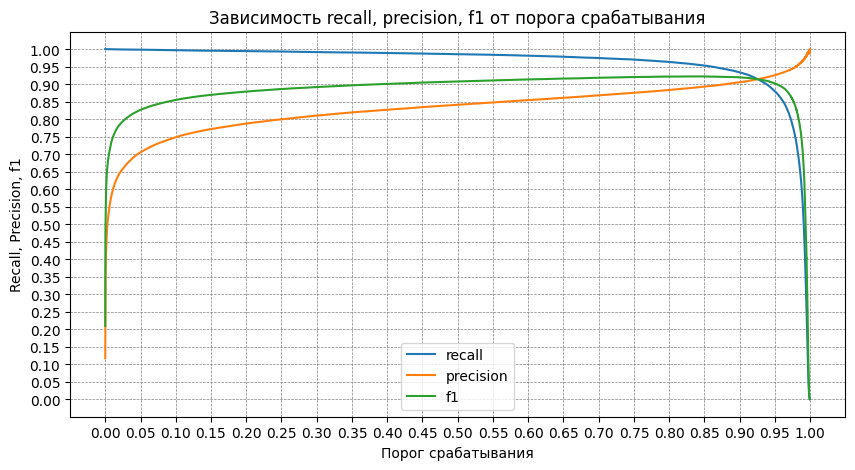

In [17]:
plt.figure(figsize=(10,5))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.title('Зависимость recall, precision, f1 от порога срабатывания')
plt.xticks(np.arange(0,1.05,0.05))
plt.yticks(np.arange(0,1.05,0.05))
plt.xlabel('Порог срабатывания')
plt.ylabel('Recall, Precision, f1')
plt.plot(np.concatenate(([0], thresholds), axis=None), recall, label='recall')
plt.plot(np.concatenate(([0], thresholds), axis=None), precision, label='precision')
plt.plot(np.concatenate(([0], thresholds), axis=None), f1_scores, label='f1')
plt.legend()
plt.show()

In [18]:
# Обучим модель на всей обучающей выборке
train_data = Pool(
    data=FeaturesData(
        num_feature_data=train[num_features].values.astype('float32'),
        cat_feature_data=train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=train[y].values
)

In [19]:
# Модель
cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,          
    depth=12,
    random_seed=RANDOM_STATE,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    logging_level='Silent',
    task_type='GPU'
)

In [20]:
cb.fit(
    train_data,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
# Вычислим предсказания при максимальном значении f1
# Вычислим значения precision и recall при всех порогах
precision, recall, thresholds = precision_recall_curve(
    train[y], cb.predict_proba(train_data)[:, 1]
)
# Вычислим значения f1 при всех порогах в обозначенном диапазоне
f1_scores = 2*recall*precision/(recall + precision)
th_for_max = thresholds[np.argmax(f1_scores)]
# Максимальное значение f1 на обучающей выборке
print(f'f1 max {np.max(f1_scores)}')

f1 max 0.9466282756090063


In [106]:
# Предсказания модели с вычисленным порогом
pred = (cb.predict_proba(test_data)[:, 1]>th_for_max).astype(int)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv('submission_16 gpu new price_dif t16 im29 1000-0.03-12 0.9467.csv', index=False)

In [36]:
# Сохраним значения, на которых модель закончила обучение,
# выходы модели перед применением сигмоиды
raw_vals = cb.predict(
    data=train_data,
    prediction_type='RawFormulaVal'
)
np.save('baseline_1.npy', raw_vals, allow_pickle=False, fix_imports=False)
raw_vals.shape

(2500000,)

In [108]:
# сохраним модель
with open('best_model_1.pkl','wb') as f:
    pickle.dump(cb, f)
# Загрузить
# with open('model.pkl', 'rb') as f:
#    clf = pickle.load(f)

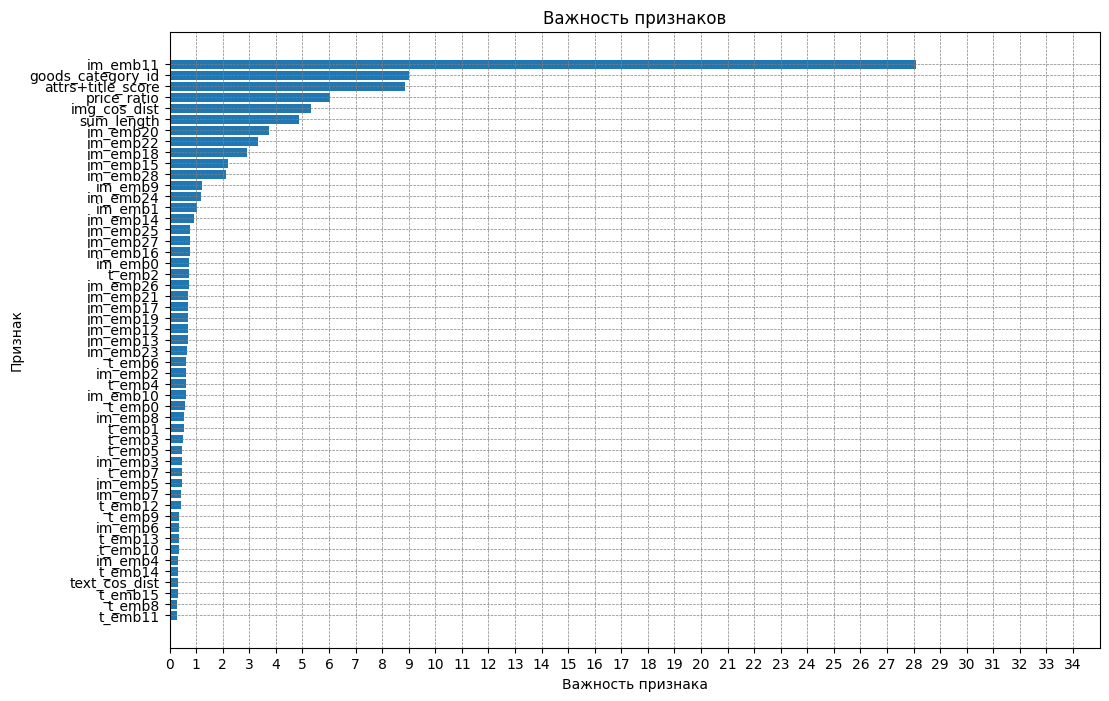

In [22]:
# Проверим важность признаков с точки зрения модели
importances = pd.Series(
    cb.feature_importances_,
    index=cb.feature_names_).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.xlim([0, 35])
plt.xticks(np.arange(0, 35, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index[::-1], width=importances[::-1])
plt.show()

#### Из текстов - 16 , из изображений - 34 признака

Те компоненты векторов изображений, которые оказались важными для модели, выделим более подробно, увеличив размерность векторов за счёт наиболее важных компонентов.

In [2]:
train = pd.read_csv('train_no_embs.csv')
test = pd.read_csv('test_no_embs.csv')

In [3]:
# Добавим эмбеддинги в датасет для повышения качества
# Загрузим ранее сохранённые эмбеддинги обучающей выборки
train_text_embs = np.load('train_text_embs.npy', allow_pickle=False)
train_img_embs = np.load('train_img_embs.npy', allow_pickle=False)

In [4]:
# Уменьшим размерность эмбеддингов, усредняя каждые 8 элементов текстовых веткоров
m = 8
train_text_embs = \
train_text_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(train_text_embs.shape[1]/m))
# и для векторов изображения
# каждые 32 элемента для разрядов 0-127
# каждые 16 элементов для разрядов 128-159
# каждые 32 элемента для разрядов 160-255
# каждые 16 элементов для разрядов 256-287
# каждые 4 элемента для разрядов 288-295
# каждые 8 элементов для разрядов 296-335
# каждые 16 элементов для разрядов 336-367
# каждые 8 элементов для разрядов 368-391
# каждые 4 элемента для разрядов 392-399
# каждые 8 элементов для разрядов 400-407
# каждые 4 элемента для разрядов 408-415
# каждые 16 элементов для разрядов 416-511
train_img_embs = \
np.concatenate(
 (train_img_embs[:,:128].reshape(-1, 32).mean(axis=1).reshape(-1, int(train_img_embs[:,:128].shape[1]/32)),
 train_img_embs[:,128:160].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,128:160].shape[1]/16)),
 train_img_embs[:,160:256].reshape(-1, 32).mean(axis=1).reshape(-1, int(train_img_embs[:,160:256].shape[1]/32)),
 train_img_embs[:,256:288].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,256:288].shape[1]/16)),
 train_img_embs[:,288:296].reshape(-1, 4).mean(axis=1).reshape(-1, int(train_img_embs[:,288:296].shape[1]/4)), 
 train_img_embs[:,296:336].reshape(-1, 8).mean(axis=1).reshape(-1, int(train_img_embs[:,296:336].shape[1]/8)),
 train_img_embs[:,336:368].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,336:368].shape[1]/16)),
 train_img_embs[:,368:392].reshape(-1, 8).mean(axis=1).reshape(-1, int(train_img_embs[:,368:392].shape[1]/8)), 
 train_img_embs[:,392:400].reshape(-1, 4).mean(axis=1).reshape(-1, int(train_img_embs[:,392:400].shape[1]/4)), 
 train_img_embs[:,400:408].mean(axis=1).reshape(-1, 1), 
 train_img_embs[:,408:416].reshape(-1, 4).mean(axis=1).reshape(-1, int(train_img_embs[:,408:416].shape[1]/4)), 
 train_img_embs[:,416:].reshape(-1, 16).mean(axis=1).reshape(-1, int(train_img_embs[:,416:].shape[1]/16))),
  axis=1
)
train_text_embs.shape, train_img_embs.shape

((2500000, 16), (2500000, 34))

In [5]:
# Объединим данные для обучения
# Наименования признаков
columns = list(train.columns) + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,34)]
train = pd.DataFrame(
    np.concatenate(
        (train.values, train_text_embs, train_img_embs),
        axis=1
    ),
    columns = columns
)
train['target'] = train['target'].astype('int32')
train[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,34)]] = \
train[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,34)]].astype('float32')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 57 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sum_length         float32
 1   attrs+title_score  float32
 2   goods_category_id  object 
 3   target             int32  
 4   price_ratio        float32
 5   text_cos_dist      float32
 6   img_cos_dist       float32
 7   t_emb0             float32
 8   t_emb1             float32
 9   t_emb2             float32
 10  t_emb3             float32
 11  t_emb4             float32
 12  t_emb5             float32
 13  t_emb6             float32
 14  t_emb7             float32
 15  t_emb8             float32
 16  t_emb9             float32
 17  t_emb10            float32
 18  t_emb11            float32
 19  t_emb12            float32
 20  t_emb13            float32
 21  t_emb14            float32
 22  t_emb15            float32
 23  im_emb0            float32
 24  im_emb1            float32
 25  im_emb2           

In [6]:
# Разделим признаки
X = ['sum_length',
     'attrs+title_score',
     'goods_category_id',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
] + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,34)]
y = ['target']

In [7]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['goods_category_id']

In [8]:
# Составим список числовых признаков
num_features = (
    train[X]
    .select_dtypes(include=['int32', 'float32', 'int64', 'float64'])
    .columns.to_list()
)
num_features

['sum_length',
 'attrs+title_score',
 'text_cos_dist',
 'img_cos_dist',
 'price_ratio',
 't_emb0',
 't_emb1',
 't_emb2',
 't_emb3',
 't_emb4',
 't_emb5',
 't_emb6',
 't_emb7',
 't_emb8',
 't_emb9',
 't_emb10',
 't_emb11',
 't_emb12',
 't_emb13',
 't_emb14',
 't_emb15',
 'im_emb0',
 'im_emb1',
 'im_emb2',
 'im_emb3',
 'im_emb4',
 'im_emb5',
 'im_emb6',
 'im_emb7',
 'im_emb8',
 'im_emb9',
 'im_emb10',
 'im_emb11',
 'im_emb12',
 'im_emb13',
 'im_emb14',
 'im_emb15',
 'im_emb16',
 'im_emb17',
 'im_emb18',
 'im_emb19',
 'im_emb20',
 'im_emb21',
 'im_emb22',
 'im_emb23',
 'im_emb24',
 'im_emb25',
 'im_emb26',
 'im_emb27',
 'im_emb28',
 'im_emb29',
 'im_emb30',
 'im_emb31',
 'im_emb32',
 'im_emb33']

In [9]:
# Загрузим ранее сохранённые эмбеддинги тестовой выборки
test_text_embs = np.load('test_text_embs.npy', allow_pickle=False)
test_img_embs = np.load('test_img_embs.npy', allow_pickle=False)

In [10]:
# Уменьшим размерность эмбеддингов, усредняя каждые 8 элементов текстовых веткоров
m = 8
test_text_embs = \
test_text_embs.reshape(-1, m).mean(axis=1).reshape(-1, int(test_text_embs.shape[1]/m))
# и для векторов изображения
# каждые 32 элемента для разрядов 0-127
# каждые 16 элементов для разрядов 128-159
# каждые 32 элемента для разрядов 160-255
# каждые 16 элементов для разрядов 256-287
# каждые 4 элемента для разрядов 288-295
# каждые 8 элементов для разрядов 296-335
# каждые 16 элементов для разрядов 336-367
# каждые 8 элементов для разрядов 368-391
# каждые 4 элемента для разрядов 392-399
# каждые 8 элементов для разрядов 400-407
# каждые 4 элемента для разрядов 408-415
# каждые 16 элементов для разрядов 416-511
test_img_embs = \
np.concatenate(
 (test_img_embs[:,:128].reshape(-1, 32).mean(axis=1).reshape(-1, int(test_img_embs[:,:128].shape[1]/32)),
 test_img_embs[:,128:160].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,128:160].shape[1]/16)),
 test_img_embs[:,160:256].reshape(-1, 32).mean(axis=1).reshape(-1, int(test_img_embs[:,160:256].shape[1]/32)),
 test_img_embs[:,256:288].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,256:288].shape[1]/16)),
 test_img_embs[:,288:296].reshape(-1, 4).mean(axis=1).reshape(-1, int(test_img_embs[:,288:296].shape[1]/4)), 
 test_img_embs[:,296:336].reshape(-1, 8).mean(axis=1).reshape(-1, int(test_img_embs[:,296:336].shape[1]/8)),
 test_img_embs[:,336:368].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,336:368].shape[1]/16)),
 test_img_embs[:,368:392].reshape(-1, 8).mean(axis=1).reshape(-1, int(test_img_embs[:,368:392].shape[1]/8)), 
 test_img_embs[:,392:400].reshape(-1, 4).mean(axis=1).reshape(-1, int(test_img_embs[:,392:400].shape[1]/4)), 
 test_img_embs[:,400:408].mean(axis=1).reshape(-1, 1), 
 test_img_embs[:,408:416].reshape(-1, 4).mean(axis=1).reshape(-1, int(test_img_embs[:,408:416].shape[1]/4)), 
 test_img_embs[:,416:].reshape(-1, 16).mean(axis=1).reshape(-1, int(test_img_embs[:,416:].shape[1]/16))),
  axis=1
)
test_text_embs.shape, test_img_embs.shape

((363835, 16), (363835, 34))

In [11]:
# Объединим данные для обучения
# Наименования признаков
columns = list(test.columns) + ['t_emb' + str(i) for i in range(0,16)] + ['im_emb' + str(i) for i in range(0,34)]
test = pd.DataFrame(
    np.concatenate(
        (test.values, test_text_embs, test_img_embs),
        axis=1
    ),
    columns = columns
)
test[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,34)]] = \
test[
    ['sum_length',
     'attrs+title_score',
     'text_cos_dist',
     'img_cos_dist',
     'price_ratio'
]   + ['t_emb' + str(i) for i in range(0,16)] \
    + ['im_emb' + str(i) for i in range(0,34)]].astype('float32')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 56 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sum_length         363835 non-null  float32
 1   attrs+title_score  363835 non-null  float32
 2   goods_category_id  363835 non-null  object 
 3   price_ratio        363835 non-null  float32
 4   text_cos_dist      363835 non-null  float32
 5   img_cos_dist       363835 non-null  float32
 6   t_emb0             363835 non-null  float32
 7   t_emb1             363835 non-null  float32
 8   t_emb2             363835 non-null  float32
 9   t_emb3             363835 non-null  float32
 10  t_emb4             363835 non-null  float32
 11  t_emb5             363835 non-null  float32
 12  t_emb6             363835 non-null  float32
 13  t_emb7             363835 non-null  float32
 14  t_emb8             363835 non-null  float32
 15  t_emb9             363835 non-null  float32
 16  t_

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    train[X], train[y],
    test_size=0.2, stratify=train[y]
)

In [13]:
# Данные для модели
train_data = Pool(
    data=FeaturesData(
        num_feature_data=X_train[num_features].values.astype('float32'),
        cat_feature_data=X_train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_train.values
)
val_data = Pool(
    data=FeaturesData(
        num_feature_data=X_val[num_features].values.astype('float32'),
        cat_feature_data=X_val[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=y_val.values
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=test[num_features].values.astype('float32'),
        cat_feature_data=test[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    )
)

Перебором гиперпараметров:
- depth максимальная глубина дерева из списка значений [6, 8, 10, 12, 13, 16],
- learning_rate шаг обучения из списка значений [0.001, 0.03, 0.05, 0.1, 0.3],
- iterations число деревьев в ансамбле из списка значений [450, 1000, 2000],
- auto_class_weights из списка значений ['Balanced', None],
- task_type из списка значений ['GPU', 'CPU'],
определим модель с наилучшим значением метрики.

In [14]:
# Модель
cb = CatBoostClassifier(
    iterations=450,
    learning_rate=0.03,          
    depth=12,
    random_seed=RANDOM_STATE,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    logging_level='Silent',
    task_type='GPU'
)

In [15]:
cb.fit(
    train_data,
    eval_set=val_data,
    plot=True,
    baseline=None,
    early_stopping_rounds=20,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [16]:
# Вычислим предсказания при максимальном значении f1
# Вычислим значения precision и recall при всех порогах
precision, recall, thresholds = precision_recall_curve(
    y_val, cb.predict_proba(val_data)[:, 1]
)
# Вычислим значения f1 при всех порогах в обозначенном диапазоне
f1_scores = 2*recall*precision/(recall + precision)
th_for_max = thresholds[np.argmax(f1_scores)]
# Максимальное значение f1 на валидационной выборке
print(f'f1 max {np.max(f1_scores)}')

f1 max 0.9219605220794016


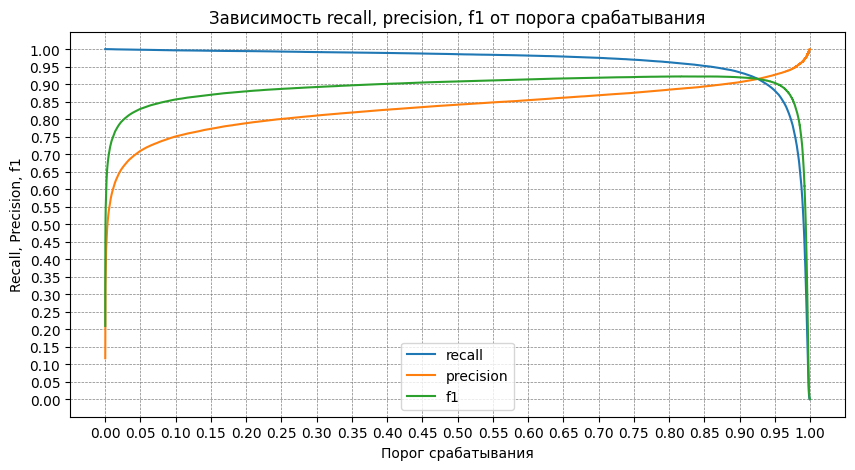

In [17]:
plt.figure(figsize=(10,5))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.title('Зависимость recall, precision, f1 от порога срабатывания')
plt.xticks(np.arange(0,1.05,0.05))
plt.yticks(np.arange(0,1.05,0.05))
plt.xlabel('Порог срабатывания')
plt.ylabel('Recall, Precision, f1')
plt.plot(np.concatenate(([0], thresholds), axis=None), recall, label='recall')
plt.plot(np.concatenate(([0], thresholds), axis=None), precision, label='precision')
plt.plot(np.concatenate(([0], thresholds), axis=None), f1_scores, label='f1')
plt.legend()
plt.show()

In [18]:
# Обучим модель на всей обучающей выборке
train_data = Pool(
    data=FeaturesData(
        num_feature_data=train[num_features].values.astype('float32'),
        cat_feature_data=train[cat_features].values,
        num_feature_names=num_features,
        cat_feature_names=cat_features
    ),
    label=train[y].values
)

In [19]:
# Модель
cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,          
    depth=12,
    random_seed=RANDOM_STATE,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    logging_level='Silent',
    task_type='GPU'
)

In [20]:
cb.fit(
    train_data,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
# Вычислим предсказания при максимальном значении f1
# Вычислим значения precision и recall при всех порогах
precision, recall, thresholds = precision_recall_curve(
    train[y], cb.predict_proba(train_data)[:, 1]
)
# Вычислим значения f1 при всех порогах в обозначенном диапазоне
f1_scores = 2*recall*precision/(recall + precision)
th_for_max = thresholds[np.argmax(f1_scores)]
# Максимальное значение f1 на обучающей выборке
print(f'f1 max {np.max(f1_scores)}')

f1 max 0.9472748471284022


In [106]:
# Предсказания модели с вычисленным порогом
pred = (cb.predict_proba(test_data)[:, 1]>th_for_max).astype(int)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv('submission_17 gpu new price_dif t16 im34 1000-0.03-12 0.9467.csv', index=False)

In [36]:
# Сохраним значения, на которых модель закончила обучение,
# выходы модели перед применением сигмоиды
raw_vals = cb.predict(
    data=train_data,
    prediction_type='RawFormulaVal'
)
np.save('baseline_2.npy', raw_vals, allow_pickle=False, fix_imports=False)
raw_vals.shape

(2500000,)

In [108]:
# сохраним модель
with open('best_model_2.pkl','wb') as f:
    pickle.dump(cb, f)
# Загрузить
# with open('model.pkl', 'rb') as f:
#    clf = pickle.load(f)

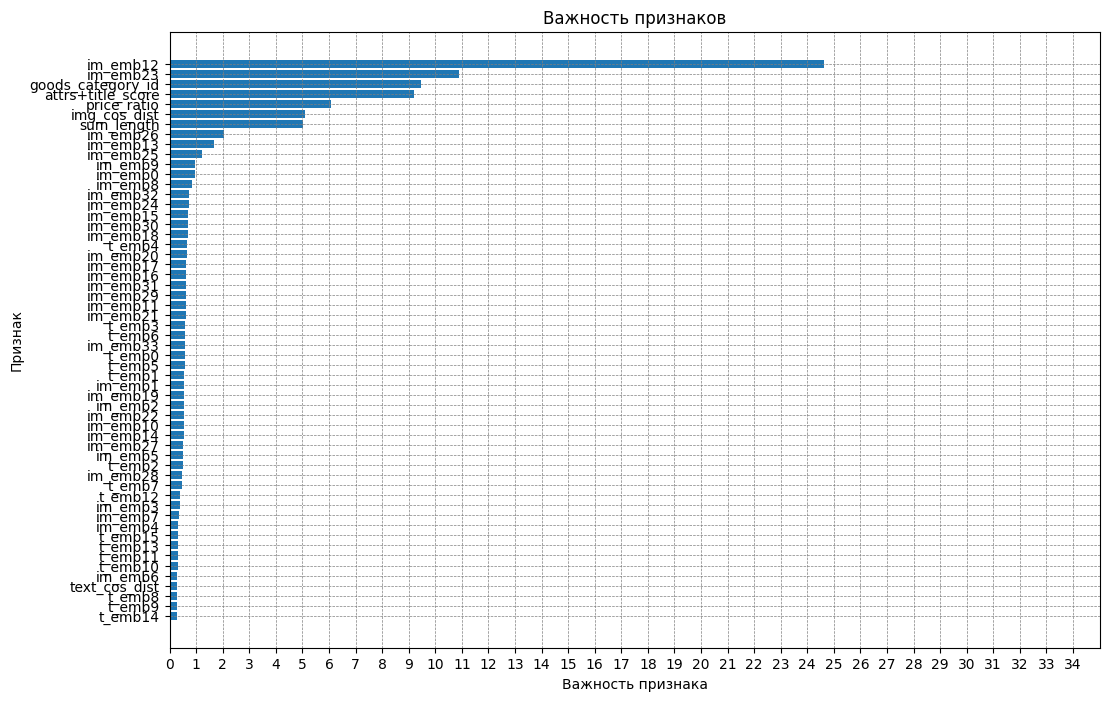

In [22]:
# Проверим важность признаков с точки зрения модели
importances = pd.Series(
    cb.feature_importances_,
    index=cb.feature_names_).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.xlim([0, 35])
plt.xticks(np.arange(0, 35, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index[::-1], width=importances[::-1])
plt.show()

Наилучший вариант показала модель с 16 признаками на основе текстовых векторов и 29 признаками на основе векторов изображений. В качестве эксперимента попробуем комбинацию предсказаний трёх рассмотренных моделей.

In [ ]:
sub13 = pd.read_csv('submission_13 gpu new price_dif t16 im16 1000-0.03-12 0.9446.csv')
sub16 = pd.read_csv('submission_16 gpu new price_dif t16 im29 1000-0.03-12 0.9467.csv')
sub17 = pd.read_csv('submission_17 gpu new price_dif t16 im34 1000-0.03-12 0.9467.csv')
combine = (sub13['target'] + sub16['target'] + sub17['target'])
combine[combine==1] = 0
combine[combine==2] = 1
combine[combine==3] = 1
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = combine
sample_submission.to_csv('submission_18 combination.csv', index=False)

## Выводы

В ходе работы выполнена загрузка и предобработка данных, созданы дополнительные признаки, основанные на отличии цен и на основе эмбеддингов текстов и изображений. В ходе экспериментов с моделями на основе бустинга из библиотеки catboost выбрана наилучшая. 

Дальнейшие шаги по улучшению:
- попробовать другие варианты выбора признаков из эмбеддингов, технологии сокращения размерности,
- провести эксперименты с нейронными сетями.